In [85]:

import os
import pandas as pd
import numpy as np
import calendar


from matplotlib.lines import Line2D

from glob import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import seaborn as sns



In [86]:
# matched_up_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/matched_DT_6hours_TW/' #finding pairs in MATCH_TIME_WINDOW = 6.0; 
stat_ret='DT' #analysis on dark target and then used the plot name
# stat_ret='DB' #analysis on dark target and then used the plot name
matched_up_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/matched_{}_1hours_TW/'.format(stat_ret) #finding pairs in MATCH_TIME_WINDOW = 1.0; 

name_tag=matched_up_dir.split('/')[-2]#name tag for the matched files, for instance matched_6hours_TW
plots_dir='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/plots/'


#
/****** Matching  parameters used ******/
# 
NVLDAER = 2;  /* minimum number of valid AERONET measurements used for averaging */
# 
MATCH_TIME_WINDOW = 1.0;  /* AERONET matching time window in hour (centered on satellite overpass time) */ 
# 
MATCH_RADIUS = 27.5;      /* Satellite retrievals matching spatial domain (radius [km] of circle centered on station)  */ 
# 
MIN_N_MATCH_PIX = 2;      /* Minimum number of pixels within matching domain */




WE ADD ANOTHER STEP IN THE ANALYISS TO MAKE SURE only high qa is used in averaging int(qf) >= 2
we included mimum 9 clean pixel after that from virrs and min 5 aeroent mesurment during the overlap of 1 hour

#for creating the std fit of covariance error we at least need 3 member in each bin -->


Functions

In [87]:

def optimize_regression_fit_np(x, y, state='aod2aod', max_iterations=100, tolerance=0.01):
    """
    Fit a linear regression using np.polyfit and optimize the fit to ensure at least one standard deviation
    of the data fits within the regression line.

    Parameters:
    - x=df[x_col] the input of regression 
    - y=df[y_col] the output of regression 
    - max_iterations (int): Maximum number of iterations for optimization.
    - tolerance (float): Tolerance for stopping the optimization.
    

    Returns:
    - slope (float): Optimized slope of the regression line.
    - intercept (float): Optimized intercept of the regression line.
    - std_within_fit (float): Standard deviation of points within the fit.
    """


    # Initial fit using np.polyfit
    slope, intercept = np.polyfit(x, y, 1)
    # Optimization loop
    for iteration in range(max_iterations):
        # # Identify points within one standard deviation
        # within_std = np.abs(residuals) <= std
    # Calculate initial upper and lower bounds
        if state=='aod2aod':
            upper_bound = x+(slope * x + intercept)
            lower_bound = x-(slope * x + intercept)
        # elif state=='error2aod':
        #     print('error2aod')

        #     # slope and intercept of equeation are basically for standard deviation of errors
        #     upper_bound=slope_error * x + intercept_error+slope * x + intercept
        #     lower_bound=slope_error * x + intercept_error-slope * x - intercept

        # Check how many points lie within the bounds
        within_bounds = (y >= lower_bound) & (y <= upper_bound)
        percentage_within_bounds = np.sum(within_bounds) / len(y)
        # Print progress
        print(f"Iteration {iteration + 1}: {percentage_within_bounds:.2%} of points within bounds.")
        # If 68% of the points are within bounds, stop optimization
        if percentage_within_bounds >= 0.68:
            print(f"Optimization converged after {iteration + 1} iterations.")
            break

        # Adjust slope and intercept to improve fit
        adjustment_factor = tolerance * (1 - percentage_within_bounds)
        slope += adjustment_factor * np.sign(np.mean(y - (slope * x + intercept)))
        intercept += adjustment_factor * np.sign(np.mean(y - (slope * x + intercept)))

    return slope, intercept, percentage_within_bounds

In [88]:
# # def optimize_regression_fit_np_error_2aod(df, x_col, y_col, max_iterations=100, tolerance=0.01):
  
#     """
#     Fit two linear regressions (mean and standard deviation) on binned data and optimize the fit to ensure
#     at least 68% of the data lies within the combined bounds.

#     Parameters:
#     - df (pd.DataFrame): The DataFrame containing the data.
#     - x_col (str): Column name for the x-axis (independent variable).
#     - y_col (str): Column name for the y-axis (dependent variable).
#     - max_iterations (int): Maximum number of iterations for optimization.
#     - tolerance (float): Adjustment factor for slopes and intercepts during optimization.

#     Returns:
#     - slope_mean (float): Optimized slope of the mean regression line.
#     - intercept_mean (float): Optimized intercept of the mean regression line.
#     - slope_std (float): Optimized slope of the standard deviation regression line.
#     - intercept_std (float): Optimized intercept of the standard deviation regression line.
#     - percentage_within_bounds (float): Final percentage of points within the bounds.
#     """
#     # Bin the data into intervals of 0.1 along the x-axis
#     bins = np.arange(df[x_col].min(), df[x_col].max() + 0.1, 0.1)
#     bin_centers = (bins[:-1] + bins[1:]) / 2
#     means = []
#     stds = []

#     # Calculate mean and standard deviation for each bin
#     for i in range(len(bins) - 1):
#         bin_data = df[(df[x_col] >= bins[i]) & (df[x_col] < bins[i + 1])]
#         means.append(bin_data[y_col].mean())
#         stds.append(bin_data[y_col].std())

#     # Remove NaN values from means
#     means = np.array(means)
#     stds = np.array(stds)
#     bin_centers = bin_centers[~np.isnan(means)]
#     means = means[~np.isnan(means)]
    

    # # Initial fits for mean and standard deviation
    # slope_mean, intercept_mean = np.polyfit(bin_centers, means, 1)

    # bin_centers = (bins[:-1] + bins[1:]) / 2
    # bin_centers = bin_centers[~np.isnan(stds)]
    # stds = stds[~np.isnan(stds)]
    # slope_std, intercept_std = np.polyfit(bin_centers, stds, 1)

    # # Optimization loop
    # for iteration in range(max_iterations):
    #     # Calculate the upper and lower bounds
    #     x = df[x_col].values
    #     y = df[y_col].values
    #     upper_bound = slope_std * x + intercept_std + (slope_mean * x + intercept_mean)
    #     lower_bound = -slope_std * x - intercept_std + (slope_mean * x + intercept_mean)


    #     # Check how many points lie within the bounds
    #     within_bounds = (y >= lower_bound) & (y <= upper_bound)
    #     percentage_within_bounds = np.sum(within_bounds) / len(y)

    #     # Print progress
    #     print(f"Iteration {iteration + 1}: {percentage_within_bounds:.2%} of points within bounds.")

    #     # If 68% of the points are within bounds, stop optimization
    #     if percentage_within_bounds >= 0.68:
    #         print(f"Optimization converged after {iteration + 1} iterations.")
    #         break

    #     # Adjust slopes and intercepts to improve fit
    #     adjustment_factor = tolerance * (1 - percentage_within_bounds)
    #     slope_mean += adjustment_factor * np.sign(np.mean(y - (slope_mean * x + intercept_mean)))
    #     intercept_mean += adjustment_factor * np.sign(np.mean(y - (slope_mean * x + intercept_mean)))
    #     # slope_std += adjustment_factor * np.sign(np.mean(np.abs(y - (slope_mean * x + intercept_mean)) - (slope_std * x + intercept_std)))
    #     # intercept_std += adjustment_factor * np.sign(np.mean(np.abs(y - (slope_mean * x + intercept_mean)) - (slope_std * x + intercept_std)))
    #     # slope_std += adjustment_factor * np.sign(- (slope_std * x + intercept_std))
    #     # intercept_std += adjustment_factor * np.sign(- (slope_std * x + intercept_std))
    #      # Adjust slope_std to grow positively if residuals increase with x
    #     # residuals = np.abs(y - (slope_mean * x + intercept_mean))
    #     # slope_std += adjustment_factor * np.sign(np.mean(residuals - (slope_std * x + intercept_std)))
    #     # intercept_std += adjustment_factor * np.sign(np.mean(residuals - (slope_std * x + intercept_std)))


    # return slope_mean, intercept_mean, slope_std, intercept_std, percentage_within_bounds

In [89]:
def plot_relationship(
    df, x_col, y_col, hue_col=None, title="", xlabel="", ylabel="", 
    legend_title=None, legend_loc="best", legend_ncols=1, legend_bbox_to_anchor=None, 
    save_path=None,one_one_line=True, regression=True,plot_error_bar=False, xlim=None, ylim=None, alpha=0.5, figsize=(10, 6), fontsize=12, palette=None, ax=None, use_palette_and_marker=False
):
    """
    Create a scatter plot with optional regression line, equation, R², and customizable palette.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - x_col (str): Column name for the x-axis.
    - y_col (str): Column name for the y-axis.
    - hue_col (str, optional): Column name for the hue (color grouping).
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis.
    - legend_title (str, optional): Title for the legend.
    - legend_loc (str): Location of the legend (e.g., 'upper left', 'best').
    - legend_ncols (int): Number of columns in the legend.
    - legend_bbox_to_anchor (tuple, optional): Position of the legend relative to the plot.
    - save_path (str, optional): Path to save the plot as a file.
    - regression (bool): Whether to include a regression line.
    - xlim (tuple, optional): Limits for the x-axis (min, max).
    - ylim (tuple, optional): Limits for the y-axis (min, max).
    - alpha (float): Transparency of the scatter points.
    - figsize (tuple): Size of the plot (width, height).
    - fontsize (int): Font size for labels, title, and legend.
    - palette (str or list, optional): Color palette for the plot. If None, a random discrete palette is used.
    - use_palette_and_marker (bool): Whether to use a palette and markers for distinct groups.
    - ax (matplotlib.axes.Axes, optional): Axis to plot on. If None, a new figure is created.
   
    """
    # Define 7 distinct markers
    markers = ['o', 's', '^', 'D', 'v', 'P', '*']
    slope, intercept = None, None
    slope_std, intercept_std = None, None

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        new_figure = True
    
    # Create scatter plot
    
    # Create scatter plot with customizable markers
    if hue_col and use_palette_and_marker:
        unique_hues = df[hue_col].unique()
        for i, hue in enumerate(unique_hues):
            subset = df[df[hue_col] == hue]
            sns.scatterplot(
                x=x_col, y=y_col, data=subset, alpha=alpha, ax=ax,
                label=hue, marker=markers[i % len(markers)]  # Cycle through markers
            )
    else:
        sns.scatterplot(
            x=x_col, y=y_col, hue=hue_col, data=df, alpha=alpha, palette=palette, ax=ax
        )
    # one to one line
    if one_one_line:
        x_one=np.linspace(0, xlim[1], 100)
        y_one=x_one
        ax.plot(x_one, y_one, color='black', linestyle='--', label='1:1 Line')
    # Add regression line and equation if requested
    if regression:
        print('regression')
        if plot_error_bar:
            slope, intercept = np.polyfit(df[x_col], df[y_col], 1)
        else:
            slope, intercept,temp =optimize_regression_fit_np(df[x_col], df[y_col])
        x = np.linspace(df[x_col].min(),xlim[1], 100)
        y = slope * x + intercept
        ax.plot(x, y, color='red', linestyle='--', label=f'Y = {slope:.2f}X + {intercept:.2f}')
        
        # Calculate correlation coefficient and R²
        correlation = df[x_col].corr(df[y_col])
        r_squared = correlation**2
        
        # Add regression equation and R² to the plot
        if plot_error_bar:
             ax.text(
            0.05, 0.91, f'Mean = {slope:.2f}X + {intercept:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
        else:
            ax.text(
                0.05, 0.91, f'Y = {slope:.2f}X + {intercept:.2f}', 
                transform=ax.transAxes, fontsize=fontsize
            )
        
        
    # Add error bars if requested
    if plot_error_bar:
        print('plot_error_bar')
        # Bin the data into intervals of 0.1 along the x-axis
        bins = np.arange(df[x_col].min(), df[x_col].max() + 0.1, 0.1)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        means = []
        stds = []
        
        for i in range(len(bins) - 1):
            bin_data = df[(df[x_col] >= bins[i]) & (df[x_col] < bins[i + 1])]
            means.append(bin_data[y_col].mean())
            if len(bin_data) >= 3:
                stds.append(bin_data[y_col].std())
            else:
                stds.append(np.nan)
        
        # Plot error bars
        ax.errorbar(bin_centers, means, yerr=stds, fmt='o', color='black', capsize=3, label='STD')
        # also estiamte the equation of how std values change with x (AOD)
        stds = np.array(stds)
        bin_centers = bin_centers[~np.isnan(stds)]
        stds = stds[~np.isnan(stds)]

      

        slope_std, intercept_std = np.polyfit(bin_centers, stds, 1)
        slope_mean=slope
        intercept_mean=intercept
        # slope_std, intercept_std ,temp =optimize_regression_fit_np_error_2aod(df,x_col, y_col)
        # slope_mean, intercept_mean, slope_std, intercept_std, percentage_within_bounds = optimize_regression_fit_np_error_2aod(
        #     df=df,
        #     x_col='satMean550',
        #     y_col='bias'
        # )
        # slope_std, intercept_std ,temp =optimize_regression_fit_np(bin_centers, stds,'error2aod',slope, intercept)
        x = np.linspace(df[x_col].min(),xlim[1], 100)
        y = (slope_mean+slope_std) * x + intercept_mean+intercept_std
        ax.plot(x, y, color='red', linestyle='dashdot', label=f'Y = upper bound: {slope+slope_std:.2f}X + {intercept+intercept_std:.2f}')
        y = (slope_mean-slope_std) * x + intercept_mean-intercept_std
        ax.plot(x, y, color='red', linestyle='dashdot', label=f'Y =  lower bound: {slope-slope_std:.2f}X + {intercept-intercept_std:.2f}')
        #add a text for this equation
        ax.text(
            0.05, 0.84, f'Std = {slope_std:.2f}X + {intercept_std:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
        

        upper_bound = (slope_std * df[x_col] + intercept_std) + (slope* df[x_col] + intercept)
        lower_bound = -(slope_std * df[x_col] + intercept_std) + (slope * df[x_col] + intercept)

        # Check how many points lie within the bounds
        within_bounds = (df[y_col] >= lower_bound) & (df[y_col] <= upper_bound)
        percentage_within_bounds = np.sum(within_bounds) / len(df[x_col]) * 100

        # Print the result
        print(f"Percentage of Points Within Bounds: {percentage_within_bounds:.2f}%")
            # add a text number of data points
  
    else:
        ax.text(
            0.05, 0.84, f'R² = {r_squared:.2f}', 
            transform=ax.transAxes, fontsize=fontsize
        )
       
    n_data_points = len(df)
    ax.text(
        0.05, 0.77, f'N = {n_data_points}', 
        transform=ax.transAxes, fontsize=fontsize
    )
    # Set the grid
    #grid off
    ax.grid(False)
    # Add labels and title
    ax.set_title(title, fontsize=fontsize)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    
    # Set axis limits if provided
    if xlim:
        ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    
    # Adjust legend
    if hue_col and legend_title:
        ax.legend(
            title=legend_title, 
            bbox_to_anchor=legend_bbox_to_anchor, 
            loc=legend_loc, 
            ncol=legend_ncols, 
            fontsize=fontsize
        )
    
    # Save the plot if a path is provided
    if save_path and new_figure:  # Only save if a new figure was created
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
    
    # Show the plot if a new figure was created
    if ax is None:
        plt.show()
     # Return the regression and error bar parameters
    return slope, intercept, slope_std, intercept_std

Read data

In [90]:
#read all the files in the matched_up directory , clean up nan


matched_up_files=glob(matched_up_dir+'*.csv')
matched_up_files.sort()

#READ EACH FILE IN PANDAS AND CONCATENATE
matched_up_df=pd.DataFrame()
for file in matched_up_files:
    df=pd.read_csv(file)
    matched_up_df=pd.concat([matched_up_df,df],ignore_index=True)
matched_up_df['date']=matched_up_df['date'].astype(str)
#IF aerMean550 is -999 exclude the row
matched_up_df=matched_up_df[matched_up_df['aerMean550'] != -999]
print(len(matched_up_df))


8983


In [91]:
def compute_cleaned_satMean550(data):
    data['cleaned_satMean550'] = np.nan
    data['cleaned_npix'] = np.nan
    # Split the qf and aod550 strings into lists
    for i in data.index:
        # data['qf'][i] = str(data['qf'][i]).split(';')
        # data['aod550'][i] = str(data['aod550'][i]).split(';')
        qf_list = [int(x) for x in str(data['qf'][i]).split(';')]
        aod_list = [float(x) for x in str(data['aod550'][i]).split(';')]
    # Select aod550 values where qf >= 2
        filtered_aod = []
        for aod, qf in zip(aod_list, qf_list):
            try:
                if int(qf) >= 2:
                    filtered_aod.append(float(aod))
            except Exception:
                continue
        data.loc[i, 'cleaned_satMean550'] = np.mean(filtered_aod) if filtered_aod else np.nan
        data.loc[i, 'cleaned_npixs'] = len(filtered_aod) if filtered_aod else np.nan
    # Remove rows where cleaned_satMean550 is NaN
    data = data.dropna(subset=['cleaned_satMean550'])
    # Return the mean if any values, else np.nan
    return data

matched_up_df= compute_cleaned_satMean550(matched_up_df)
matched_up_df['aerMean550_initial']=matched_up_df['satMean550']
matched_up_df['satMean550']=matched_up_df['cleaned_satMean550']

matched_up_df


date  nMeas  nPixs  satTime          staName   staLon    staLat  \
0     20210101      7     20     10.8      ASI_Malindi  40.1945  -2.99600   
1     20210101      7     18     12.5           Ilorin   4.3400   8.32000   
2     20210101      5     33     12.5  SEGC_Lope_Gabon  11.6008  -0.20155   
3     20210102      4     46     10.5           AAU_ET  38.7478   9.01917   
4     20210102     10     18     10.5      ASI_Malindi  40.1945  -2.99600   
...        ...    ...    ...      ...              ...      ...       ...   
8978  20241230     10     51      9.9   AAU_Jackros_ET  38.8208   9.01167   
8979  20241230      6      9      9.9      ASI_Malindi  40.1945  -2.99600   
8980  20241230      5      5     11.4            Metsi  27.1324 -26.49080   
8981  20241230      5      9     11.5       Maun_Tower  23.5500 -19.90000   
8982  20241230     10     31     11.6   AAU_Jackros_ET  38.8208   9.01167   

      aerMean550  aerSTD550  mean_aeronet_ae  satMean550  satSTD550  \
0       0.129794   0.004141         0.507263    0.198500   0.117402   
1       0.565672   0.024049         0.988028    0.263706   0.043269   
2       0.868718   0.015566         1.322050    0.699444   0.057748   
3       0.178212   0.005113         0.710755    0.271310   0.106898   
4       0.128364   0.005605         0.418907    0.122000   0.060064   
...          ...        ...              ...         ...        ...   
8978    0.066847   0.005892         0.737456    0.083588   0.041240   
8979    0.341444   0.019686         0.676908    0.672400   0.032212   
8980    0.181861   0.016316         1.758580    0.180400   0.030748   
8981    0.121469   0.012651         0.780196    0.165667   0.047872   
8982    0.072949   0.004270         0.724536    0.138571   0.046510   

                                                 aod550  \
0     0.279;0.104;0.241;0.268;0.294;0.607;0.217;0.12...   
1     0.262;0.397;0.269;0.244;0.279;0.262;0.377;0.27...   
2     0.751;0.76;0.723;0.755;0.753;0.695;0.686;0.714...   
3     0.272;0.324;0.292;0.087;0.323;0.307;0.267;0.32...   
4     0.042;0.129;0.095;0.113;-0.026;0.088;0.1;0.064...   
...                                                 ...   
8978  0.121;0.131;0.115;0.116;0.114;0.123;0.121;0.11...   
8979  0.67;0.706;0.612;0.661;0.71;0.691;0.619;0.663;...   
8980                       0.203;0.137;0.19;0.153;0.219   
8981  0.218;0.144;0.194;0.147;0.208;0.072;0.203;0.10...   
8982  0.172;0.146;0.153;0.174;0.15;0.199;0.135;0.19;...   

                                                     qf  \
0               3;2;2;2;1;2;2;3;3;3;2;3;3;2;3;3;3;3;3;1   
1                   3;1;3;3;3;2;3;3;3;3;3;3;3;3;3;3;3;3   
2     1;2;3;3;2;2;2;2;2;2;3;2;3;2;1;3;1;2;2;1;1;2;2;...   
3     3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;...   
4                   3;3;3;3;3;3;2;3;3;3;3;3;3;3;3;3;2;3   
...                                                 ...   
8978  3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;...   
8979                                  1;3;1;1;3;1;2;3;3   
8980                                          2;3;3;2;2   
8981                                  2;3;2;3;3;3;3;3;2   
8982  2;3;3;3;3;2;2;3;1;2;2;3;1;2;3;3;2;2;3;3;2;2;2;...   

                                                 lndSea  cleaned_satMean550  \
0               1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1            0.198500   
1                   1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1            0.263706   
2     1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...            0.699444   
3     1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...            0.271310   
4                   1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1            0.122000   
...                                                 ...                 ...   
8978  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...            0.083588   
8979                                  0;0;1;0;0;1;1;1;1            0.672400   
8980                                          1;1;1;1;1            0.180400   
8981                    

In [92]:
matched_up_df=matched_up_df[matched_up_df['cleaned_npixs'] >= 9]
matched_up_df=matched_up_df[matched_up_df['nMeas'] >= 4]
matched_up_df

date  nMeas  nPixs  satTime          staName   staLon    staLat  \
0     20210101      7     20     10.8      ASI_Malindi  40.1945  -2.99600   
1     20210101      7     18     12.5           Ilorin   4.3400   8.32000   
2     20210101      5     33     12.5  SEGC_Lope_Gabon  11.6008  -0.20155   
3     20210102      4     46     10.5           AAU_ET  38.7478   9.01917   
4     20210102     10     18     10.5      ASI_Malindi  40.1945  -2.99600   
...        ...    ...    ...      ...              ...      ...       ...   
8976  20241229     11     46     10.2   AAU_Jackros_ET  38.8208   9.01167   
8977  20241229     10     38     10.2      ASI_Malindi  40.1945  -2.99600   
8978  20241230     10     51      9.9   AAU_Jackros_ET  38.8208   9.01167   
8981  20241230      5      9     11.5       Maun_Tower  23.5500 -19.90000   
8982  20241230     10     31     11.6   AAU_Jackros_ET  38.8208   9.01167   

      aerMean550  aerSTD550  mean_aeronet_ae  satMean550  satSTD550  \
0       0.129794   0.004141         0.507263    0.198500   0.117402   
1       0.565672   0.024049         0.988028    0.263706   0.043269   
2       0.868718   0.015566         1.322050    0.699444   0.057748   
3       0.178212   0.005113         0.710755    0.271310   0.106898   
4       0.128364   0.005605         0.418907    0.122000   0.060064   
...          ...        ...              ...         ...        ...   
8976    0.092901   0.005972         0.825719    0.133522   0.072693   
8977    0.261541   0.012701         0.569659    0.333321   0.085908   
8978    0.066847   0.005892         0.737456    0.083588   0.041240   
8981    0.121469   0.012651         0.780196    0.165667   0.047872   
8982    0.072949   0.004270         0.724536    0.138571   0.046510   

                                                 aod550  \
0     0.279;0.104;0.241;0.268;0.294;0.607;0.217;0.12...   
1     0.262;0.397;0.269;0.244;0.279;0.262;0.377;0.27...   
2     0.751;0.76;0.723;0.755;0.753;0.695;0.686;0.714...   
3     0.272;0.324;0.292;0.087;0.323;0.307;0.267;0.32...   
4     0.042;0.129;0.095;0.113;-0.026;0.088;0.1;0.064...   
...                                                 ...   
8976  0.21;0.208;0.211;0.2;0.105;0.222;0.22;0.196;0....   
8977  0.371;0.364;0.451;0.409;0.496;0.448;0.395;0.41...   
8978  0.121;0.131;0.115;0.116;0.114;0.123;0.121;0.11...   
8981  0.218;0.144;0.194;0.147;0.208;0.072;0.203;0.10...   
8982  0.172;0.146;0.153;0.174;0.15;0.199;0.135;0.19;...   

                                                     qf  \
0               3;2;2;2;1;2;2;3;3;3;2;3;3;2;3;3;3;3;3;1   
1                   3;1;3;3;3;2;3;3;3;3;3;3;3;3;3;3;3;3   
2     1;2;3;3;2;2;2;2;2;2;3;2;3;2;1;3;1;2;2;1;1;2;2;...   
3     3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;...   
4                   3;3;3;3;3;3;2;3;3;3;3;3;3;3;3;3;2;3   
...                                                 ...   
8976  3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;...   
8977  3;3;1;3;3;1;3;3;3;3;3;3;3;2;2;3;3;1;3;3;3;3;3;...   
8978  3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;3;...   
8981                                  2;3;2;3;3;3;3;3;2   
8982  2;3;3;3;3;2;2;3;1;2;2;3;1;2;3;3;2;2;3;3;2;2;2;...   

                                                 lndSea  cleaned_satMean550  \
0               1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1            0.198500   
1                   1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1            0.263706   
2     1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...            0.699444   
3     1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...            0.271310   
4                   1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1            0.122000   
...                                                 ...                 ...   
8976  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...            0.133522   
8977  0;0;0;0;0;0;0;0;0;0;0;0;0;1;1;0;0;0;1;1;0;0;1;...            0.333321   
8978  1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;1;...            0.083588   
8981                    

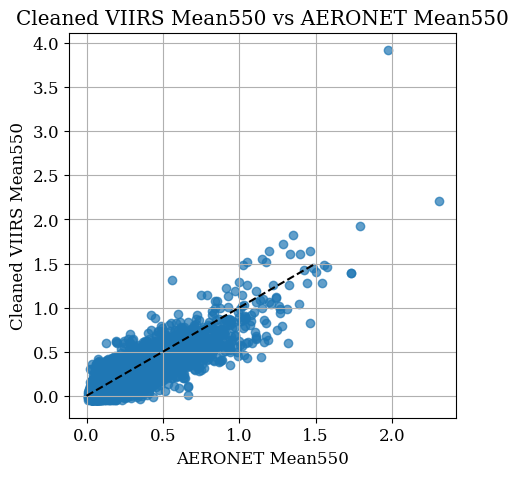

In [93]:
plt.figure(figsize=(5, 5))
plt.scatter(matched_up_df['aerMean550'], matched_up_df['cleaned_satMean550'], alpha=0.7)
# one o one line
x_one=np.linspace(0, 1.5, 100)
y_one=x_one
plt.plot(x_one, y_one, color='black', linestyle='--', label='1:1 Line')
plt.xlabel('AERONET Mean550')
plt.ylabel('Cleaned VIIRS Mean550')
plt.title('Cleaned VIIRS Mean550 vs AERONET Mean550')
plt.grid(True)
plt.show()


In [94]:
# create a new columns required
matched_up_df['year'] = matched_up_df['date'].str[:4]  # Extract year from the 'date' column
matched_up_df['bias'] = matched_up_df['aerMean550'] - matched_up_df['satMean550']
# filter the data by satMean550 excludign its 5% extreme values
# lower_bound = matched_up_df['bias'].quantile(0.025)
# upper_bound = matched_up_df['bias'].quantile(0.975)
# matched_up_df = matched_up_df[(matched_up_df['bias'] >= lower_bound) & (matched_up_df['bias'] <= upper_bound)]
print(len(matched_up_df))


6029


#plots 

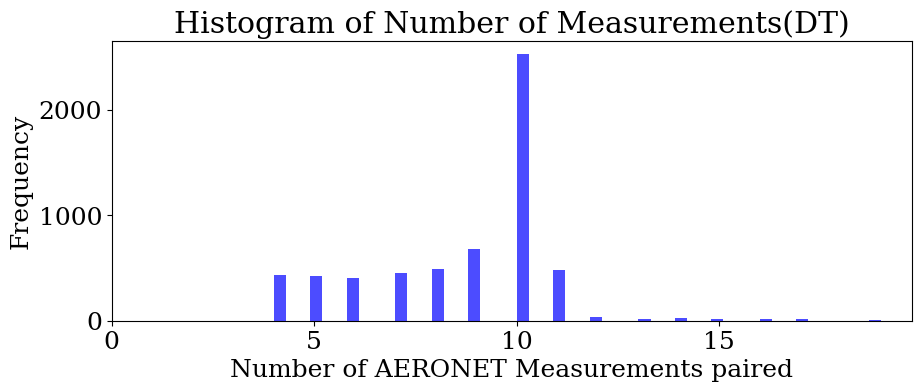

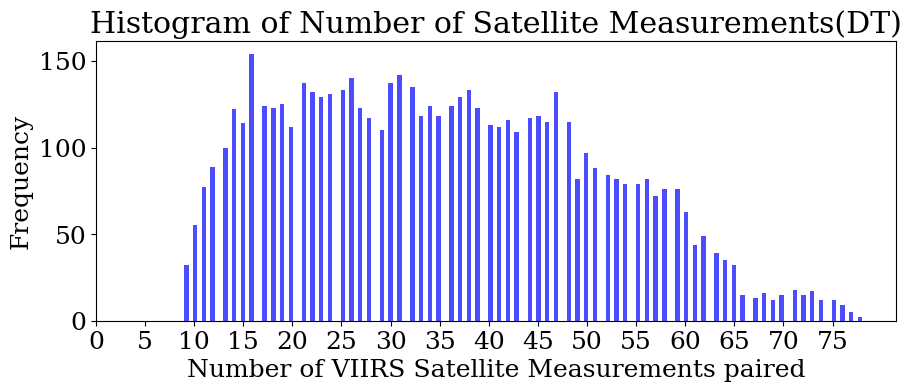

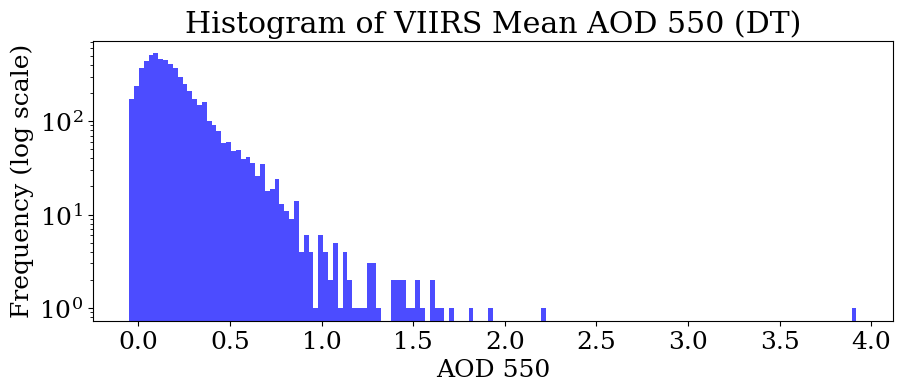

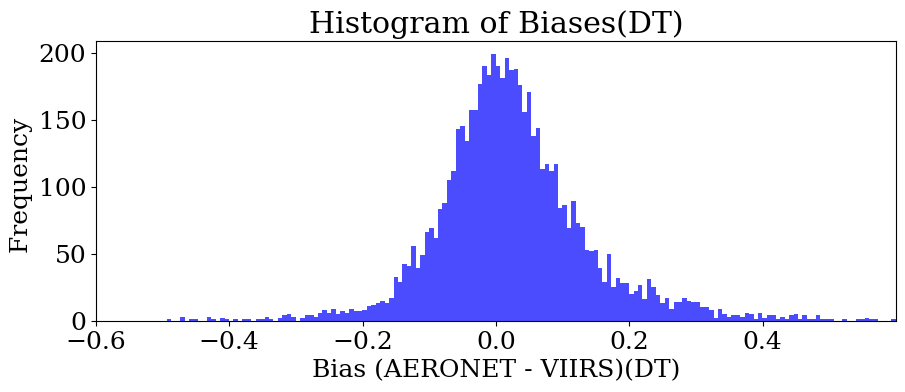

In [95]:
# plot the histogram of the number of measurements
plt.figure(figsize=(10, 4))
#increase the font size of all plots to 18
plt.rcParams.update({'font.size': 18})
plt.hist(matched_up_df['nMeas'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Number of Measurements({})'.format(stat_ret))
plt.xlabel('Number of AERONET Measurements paired')
plt.ylabel('Frequency')
# plt.grid()
# xticks at even intervals to max
plt.xticks(np.arange(0, matched_up_df['nMeas'].max()+1, 5))
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.savefig(plots_dir+name_tag+stat_ret+'_histogram_nMeas.png', dpi=300)
plt.show()

# plot the histogram of the number of sat measurements
plt.figure(figsize=(10, 4))
plt.hist(matched_up_df['nPixs'], bins=156, color='blue', alpha=0.7)
plt.title('Histogram of Number of Satellite Measurements({})'.format(stat_ret))
plt.xlabel('Number of VIIRS Satellite Measurements paired')
plt.ylabel('Frequency')
# plt.grid()
# xticks at even intervals to max
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.xticks(np.arange(0, matched_up_df['nPixs'].max()+1, 5))
plt.savefig(plots_dir+name_tag+stat_ret+'_histogram_nSatMeas.png', dpi=300)
plt.show()

#plot the histogram of AOD 550
plt.figure(figsize=(10, 4))
plt.hist(matched_up_df['satMean550'], bins=150, color='blue', alpha=0.7)
plt.title('Histogram of VIIRS Mean AOD 550 ({})'.format(stat_ret))
plt.xlabel('AOD 550')
plt.ylabel('Frequency (log scale)')
plt.yscale('log')
# plt.grid()
# xticks at even intervals to max
# plt.xticks(np.arange(-0.6, 0.6, 0.2))
# plt.xlim(-0.6, 0.6)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.savefig(plots_dir+name_tag+stat_ret+'_histogram_satMean550.png', dpi=300)
plt.show()  

#plot the histogram of biases
plt.figure(figsize=(10, 4))
plt.hist(matched_up_df['bias'], bins=400, color='blue', alpha=0.7)
plt.title('Histogram of Biases({})'.format(stat_ret))
plt.xlabel('Bias (AERONET - VIIRS)({})'.format(stat_ret))
plt.ylabel('Frequency ')
# plt.grid()
# xticks at even intervals to max
plt.xticks(np.arange(-0.6, 0.6, 0.2))
plt.xlim(-0.6, 0.6)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
plt.savefig(plots_dir+name_tag+stat_ret+'_histogram_bias.png', dpi=300)
plt.show()  

regression
Iteration 1: 87.33% of points within bounds.
Optimization converged after 1 iterations.


(0.8025458404542134, 0.01981839661665643, None, None)

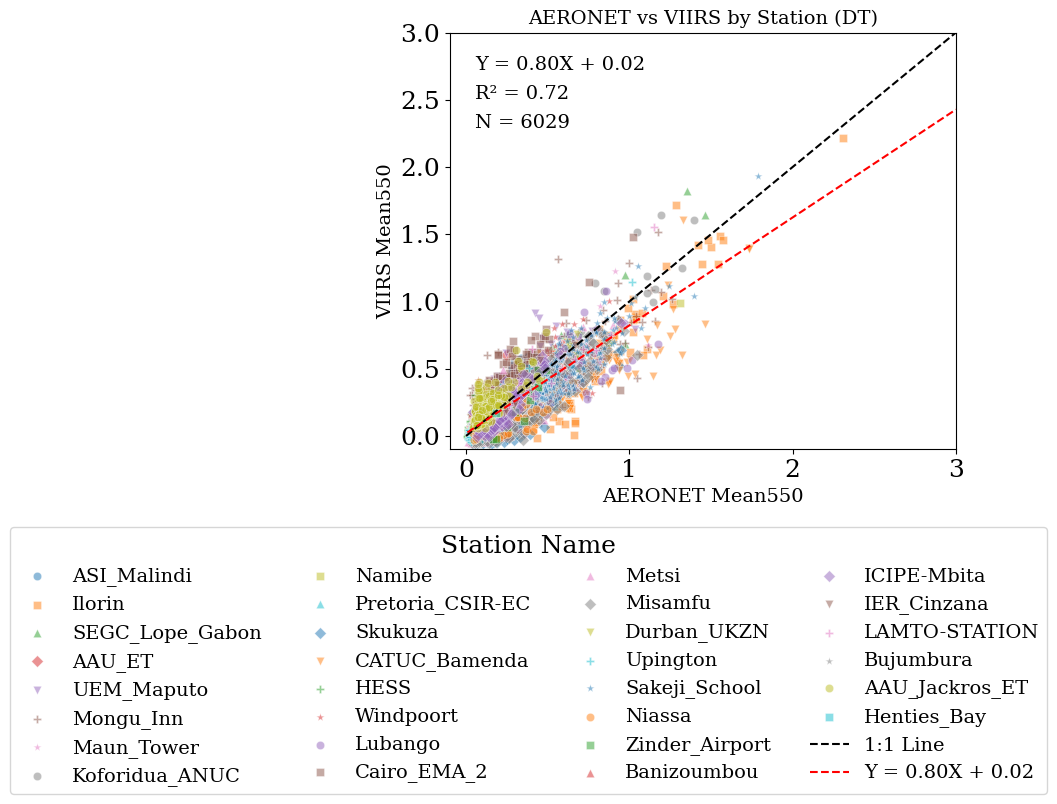

In [96]:
#make scatter plots of the aerMean550 satMean550 color by staName

plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='staName',
    title='AERONET vs VIIRS by Station ({})'.format(stat_ret),
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Station Name',
    legend_loc='lower right',
    legend_bbox_to_anchor = (1.2, -0.85),
    legend_ncols=4,
    palette='viridis',
    save_path=os.path.join(plots_dir, '{}_aeronet_vs_viirs_bysation{}.png'.format(stat_ret,name_tag)),
    regression=True,
    use_palette_and_marker=True,  # Enable palette and markers
    xlim =(-0.1, 3),
    ylim =(-0.1, 3),
    figsize =(9,14),
    fontsize=14,
    alpha=0.5
)


/tmp/ipykernel_68416/2146484579.py:54: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
/tmp/ipykernel_68416/2146484579.py:54: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


regression
Iteration 1: 72.22% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 85.35% of points within bounds.
Optimization converged after 1 iterations.


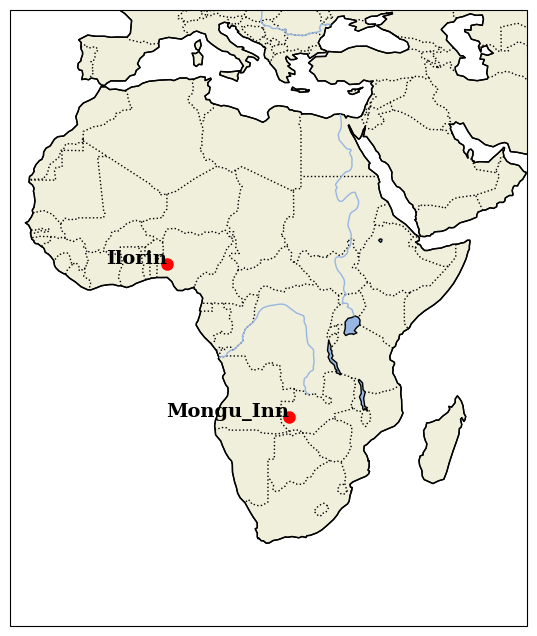

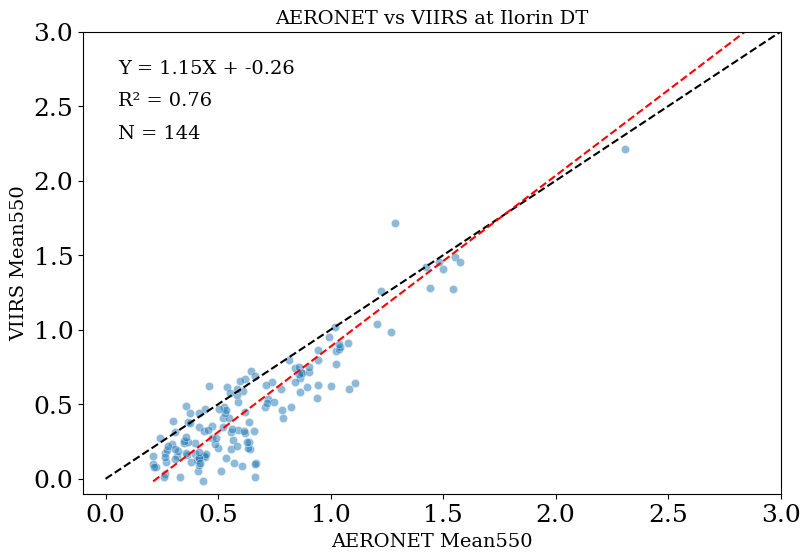

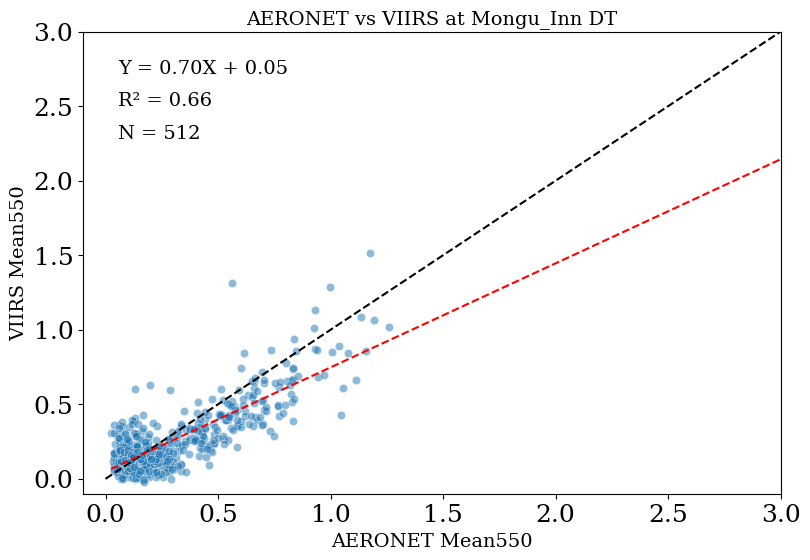

In [97]:
#select the data for the IIorin station and plot the scatter plot


stations=['Ilorin','Mongu_Inn']

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-20, 60, -40, 40])  # Set the extent to cover Africa

# Add features to the map
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black')
ax.add_feature(cfeature.RIVERS)



for station in stations:
    station_df=matched_up_df[matched_up_df['staName']==station]

    plot_relationship(
        df=station_df,
        x_col='aerMean550',
        y_col='satMean550',
        title='AERONET vs VIIRS at {} {}'.format(station, stat_ret),
        xlabel='AERONET Mean550',
        ylabel='VIIRS Mean550',
        legend_title='Station Name',
        legend_loc='lower right',
        legend_bbox_to_anchor = (1.2, -0.85),
        legend_ncols=4,
        palette='viridis',
        #save_path=os.path.join(plots_dir, 'aeronet_vs_viirs_{}.png'.format(station)),
        regression=True,
        xlim =(-0.1, 3),
        ylim =(-0.1, 3),
        figsize =(9,6),
        fontsize=14,
        alpha=0.5
    )

    #get the first data of eah df station_df[0]['lon'], station_df[0]['lat'] on a map
    ax.plot(
        station_df['staLon'].iloc[0], station_df['staLat'].iloc[0], 
        marker='o', color='red', markersize=8, 
        transform=ccrs.PlateCarree(), 
        label=station
    )
    #and add a text with the station name
    ax.text(
        station_df['staLon'].iloc[0], station_df['staLat'].iloc[0], 
        station, fontsize=14, fontweight='bold', ha='right', transform=ccrs.PlateCarree()
    )




#plot the scatter plot of the aerMean550 and satMean550 for all the stations

regression
Iteration 1: 87.33% of points within bounds.
Optimization converged after 1 iterations.


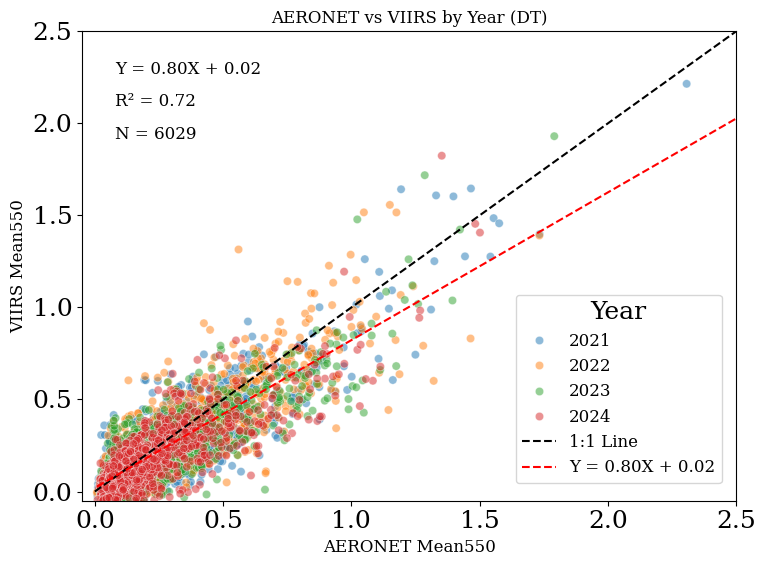

In [98]:
#make scatter plots of the aerMean550 satMean550 color by year

slope, intercept, slope_std, intercept_std=plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='year',
    title='AERONET vs VIIRS by Year ({})'.format(stat_ret),
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Year',
    legend_loc='lower left',
    legend_bbox_to_anchor=(0.65, 0.02),
    legend_ncols=1,
    save_path=os.path.join(plots_dir, '{}_aeronet_vs_viirs_byyear{}.png'.format(stat_ret,name_tag)),
    regression=True,
    xlim=(-0.05, 2.5),
    ylim=(-0.05, 2.5),
    figsize=(8, 6),
    fontsize=12,
    alpha=0.5
)



regression
Iteration 1: 85.22% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 87.82% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 85.91% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 84.44% of points within bounds.
Optimization converged after 1 iterations.


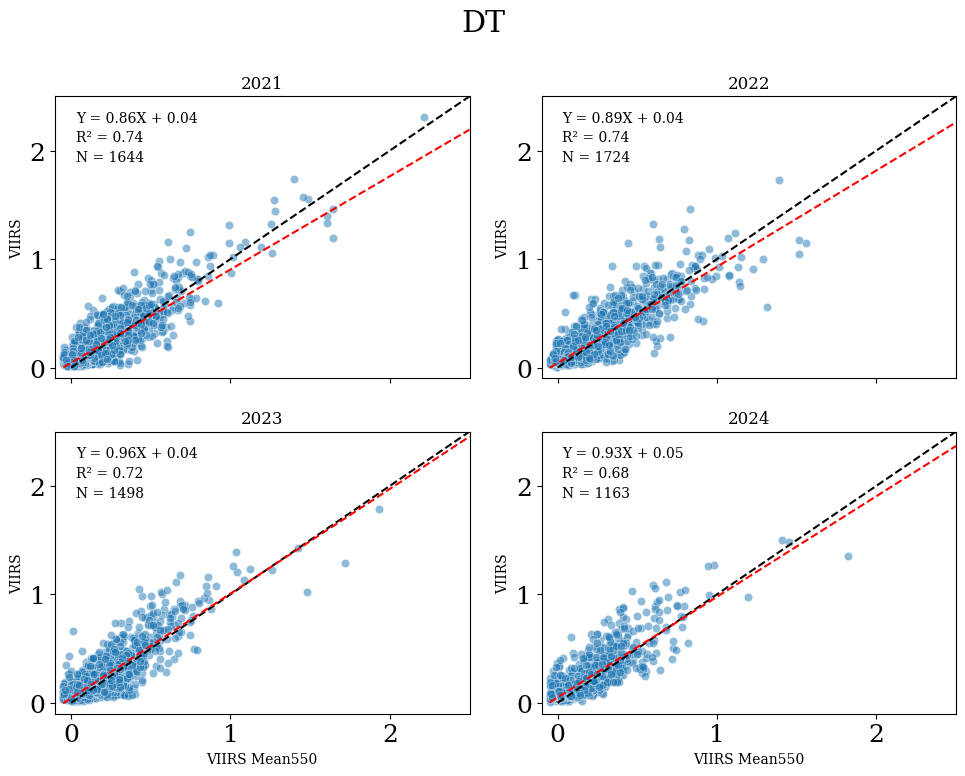

In [99]:
# Ensure the 'year' column exists in the DataFrame


unique_years = matched_up_df['year'].unique()
unique_years.sort()

# Create subplots for each year
fig, axes = plt.subplots(nrows=int(len(unique_years)/2), ncols=2, figsize=(10, 2 * len(unique_years)), sharex=True)
axes=axes.ravel()

# Loop through each year and call the plot_relationship function
for i, year in enumerate(unique_years):
    ax = axes[i] if len(unique_years) > 1 else axes  # Handle single subplot case
    year_data = matched_up_df[matched_up_df['year'] == year]  # Filter data for the current year
    
    # Call the plot_relationship function for the current year
    plot_relationship(
        ax=ax,
        df=year_data,
        x_col='satMean550',
        y_col='aerMean550',
        title=f' {year}',
        xlabel='VIIRS Mean550',
        ylabel='VIIRS',
        legend_title=None,
        legend_loc='upper right',
        legend_bbox_to_anchor=None,
        legend_ncols=1,
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-0.1, 2.5),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=10,
        palette=None  # Use default random discrete colors
    )
    ax.set_title(f'{year}', fontsize=12)
# Adjust layout and save the figure
plt.suptitle(stat_ret)
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, '{}_aeronet_vs_viirs_seperate_years{}.png'.format(stat_ret,name_tag)), dpi=300)
plt.show()

regression
plot_error_bar
Percentage of Points Within Bounds: 81.72%


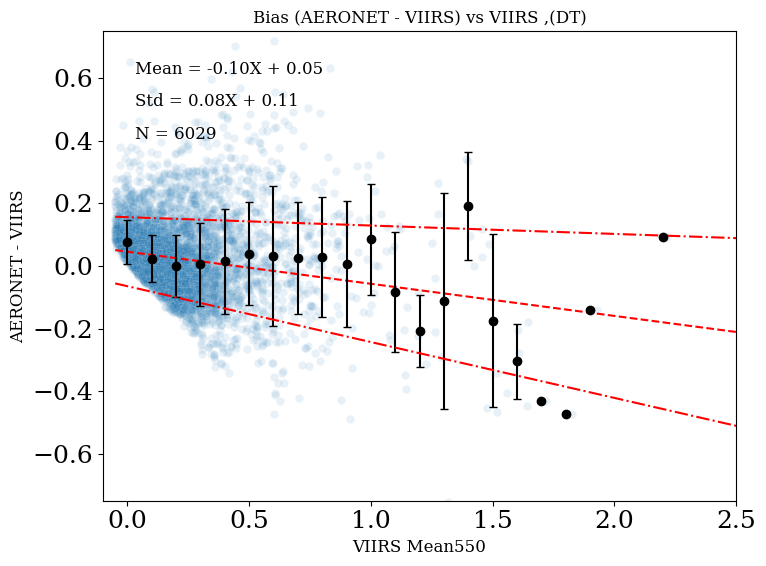

In [100]:
# Calculate the bias (AERONET - VIIRS)

slope, intercept, slope_std, intercept_std=plot_relationship(
    df=matched_up_df,
    x_col='satMean550',
    y_col='bias',
    title='Bias (AERONET - VIIRS) vs VIIRS ,({})'.format(stat_ret),
    xlabel='VIIRS Mean550',
    ylabel='AERONET - VIIRS',
    plot_error_bar=True,
    one_one_line=False,
    legend_title=None,
    legend_loc='upper right',
    save_path=os.path.join(plots_dir, '{}_error_aeronet_vs_viirs{}.png'.format(stat_ret,name_tag)),
    regression=True,
    xlim=(-0.1, 2.5),
    ylim=(-0.75, 0.75),
    alpha=0.1,
    figsize=(8, 6),
    fontsize=12,
    palette=None
)

#check what percentage of the data is within the bounds
# Calculate the upper and lower bounds
# x = matched_up_df['satMean550'].values
# y = matched_up_df['bias'].values

# upper_bound = (slope_std * x + intercept_std) + (slope* x + intercept)
# lower_bound = -(slope_std * x + intercept_std) + (slope * x + intercept)

# # Check how many points lie within the bounds
# within_bounds = (y >= lower_bound) & (y <= upper_bound)
# percentage_within_bounds = np.sum(within_bounds) / len(y) * 100

# # Print the result
# print(f"Percentage of Points Within Bounds: {percentage_within_bounds:.2f}%")


1292
regression
plot_error_bar
Percentage of Points Within Bounds: 77.17%


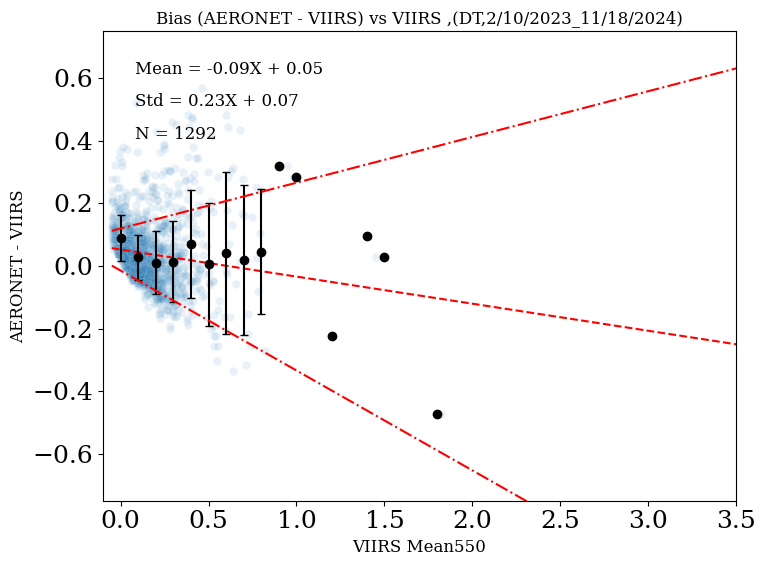

In [101]:
#same as plot above but I want 2/10/2023 – 11/18/2024
# filter the data by date
start_date = '2023-10-02'
end_date = '2024-11-18'
matched_up_df['date'] = pd.to_datetime(matched_up_df['date'])
filtered_df = matched_up_df[(matched_up_df['date'] >= start_date) & (matched_up_df['date'] <= end_date)]
print(len(filtered_df))
# Calculate the bias (AERONET - VIIRS)
slope, intercept, slope_std, intercept_std=plot_relationship(
    df=filtered_df,
    x_col='satMean550',
    y_col='bias',
    title='Bias (AERONET - VIIRS) vs VIIRS ,({},{})'.format(stat_ret,'2/10/2023_11/18/2024'),
    xlabel='VIIRS Mean550',
    ylabel='AERONET - VIIRS',
    plot_error_bar=True,
    one_one_line=False,
    legend_title=None,
    legend_loc='upper right',
    save_path=os.path.join(plots_dir, '{}_error_aeronet_vs_viirs_filtered{}{}.png'.format(stat_ret,name_tag,'2102023-11182024')),
    regression=True,
    xlim=(-0.1, 3.5),
    ylim=(-0.75, 0.75),
    alpha=0.1,
    figsize=(8, 6),
    fontsize=12,
    palette=None
)

In [102]:
# df=matched_up_df
# x_col='satMean550'
# y_col='bias'
 


# # slope, intercept = np.polyfit(df[x_col], df[y_col], 1) 
# # Bin the data into intervals of 0.1 along the x-axis
# bins = np.arange(df[x_col].min(), df[x_col].max() + 0.1, 0.1)
# bin_centers = (bins[:-1] + bins[1:]) / 2
# means = []
# stds = []

# for i in range(len(bins) - 1):
#     bin_data = df[(df[x_col] >= bins[i]) & (df[x_col] < bins[i + 1])]
#     means.append(bin_data[y_col].mean())
#     stds.append(bin_data[y_col].std())
# means = np.array(means)

# bin_centers = bin_centers[~np.isnan(means)]
# means = means[~np.isnan(means)]
# slope, intercept = np.polyfit(bin_centers, means, 1) 
# # Plot error bars
# # ax.errorbar(bin_centers, means, yerr=stds, fmt='o', color='black', capsize=3, label='STD')
# # also estiamte the equation of how std values change with x (AOD)
# stds = np.array(stds)
# bin_centers = (bins[:-1] + bins[1:]) / 2
# bin_centers = bin_centers[~np.isnan(stds)]
# stds = stds[~np.isnan(stds)]
# slope_std, intercept_std = np.polyfit(bin_centers, stds, 1)
# # slope_std, intercept_std ,temp =optimize_regression_fit_np(bin_centers, stds)
# #add a text for this equation





regression
plot_error_bar
Percentage of Points Within Bounds: 81.63%
regression
plot_error_bar
Percentage of Points Within Bounds: 78.83%
regression
plot_error_bar
Percentage of Points Within Bounds: 78.17%
regression
plot_error_bar
Percentage of Points Within Bounds: 78.25%


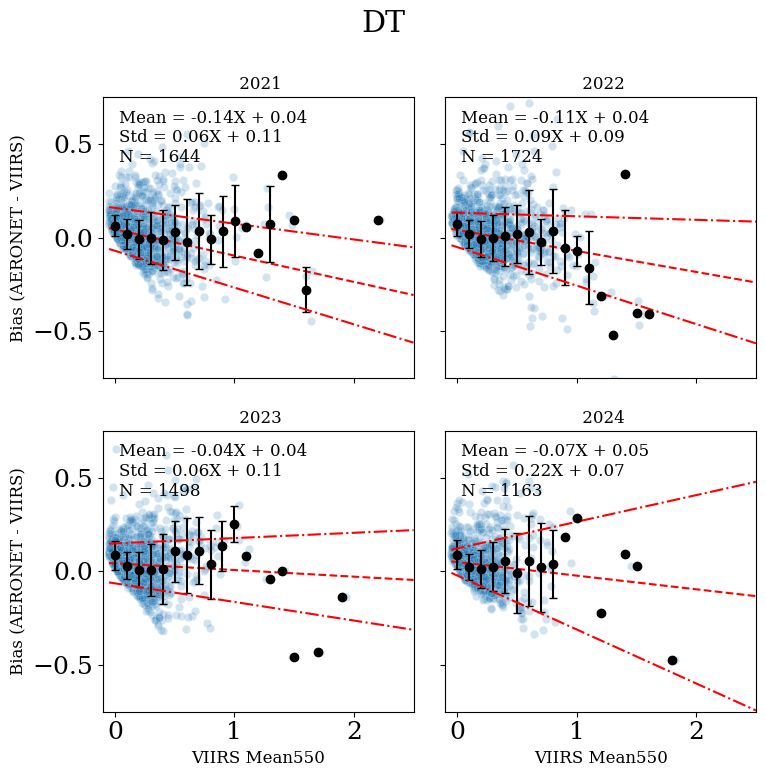

In [103]:
# Ensure the 'year' column exists in the DataFrame
unique_years = matched_up_df['year'].unique()
unique_years.sort()

# Create subplots for each year
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_years) / 2)), ncols=2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each year and plot the bias
for i, year in enumerate(unique_years):
    ax = axes[i]
    year_data = matched_up_df[matched_up_df['year'] == year]
    
    #call the plot_relationship function for the current year
    plot_relationship(
        ax=ax,
        df=year_data,
        x_col='satMean550',
        y_col='bias',
        title=f' {year}',
        xlabel='VIIRS Mean550',
        ylabel='Bias (AERONET - VIIRS)',
        one_one_line=False,
        plot_error_bar=True,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-0.75, 0.75),
        alpha=0.2,
        figsize=(3, 3),
        fontsize=12,
        palette=None
    )


# Hide unused subplots if any
plt.suptitle(stat_ret)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
save_path=os.path.join(plots_dir, '{}_aerror_aeronet_vs_viirs_seperate_years{}.png'.format(stat_ret,name_tag))
plt.savefig(save_path, dpi=300)
plt.tight_layout()
plt.show()

regression
Iteration 1: 87.33% of points within bounds.
Optimization converged after 1 iterations.


(0.8025458404542134, 0.01981839661665643, None, None)

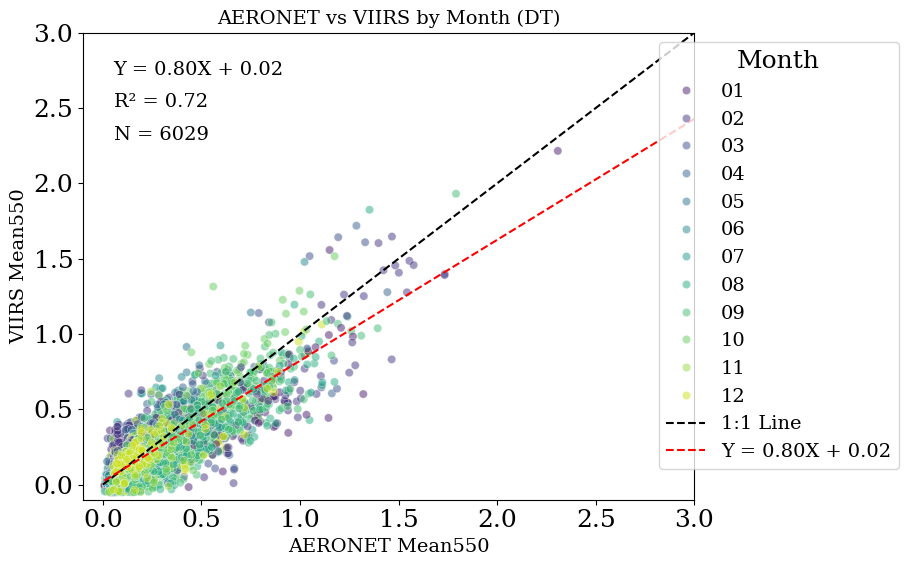

In [104]:
#make scatter plots of the aerMean550 satMean550 color by month
# matched_up_df['month']=matched_up_df['date'].str[4:6]
matched_up_df['month']=matched_up_df['date'].dt.strftime('%m')
plot_relationship(
    df=matched_up_df,
    x_col='aerMean550',
    y_col='satMean550',
    hue_col='month',
    title='AERONET vs VIIRS by Month ({})'.format(stat_ret),
    xlabel='AERONET Mean550',
    ylabel='VIIRS Mean550',
    legend_title='Month',
    legend_loc='upper right',
    legend_bbox_to_anchor=(1.35, 1),
    legend_ncols=1,
    save_path=os.path.join(plots_dir, '{}_aeronet_vs_viirs_bymonth{}.png'.format(stat_ret,name_tag)),
    regression=True,
    xlim=(-0.1, 3),
    ylim=(-0.1, 3),
    figsize=(10, 6),
    fontsize=14,
    alpha=0.5,
    palette='viridis'
)

regression
Iteration 1: 91.69% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 89.61% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 85.96% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 90.20% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 80.58% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 80.36% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 80.48% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 82.56% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 88.51% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 86.62% of points within bounds.
Optimization converged after 1 iterations.
regression

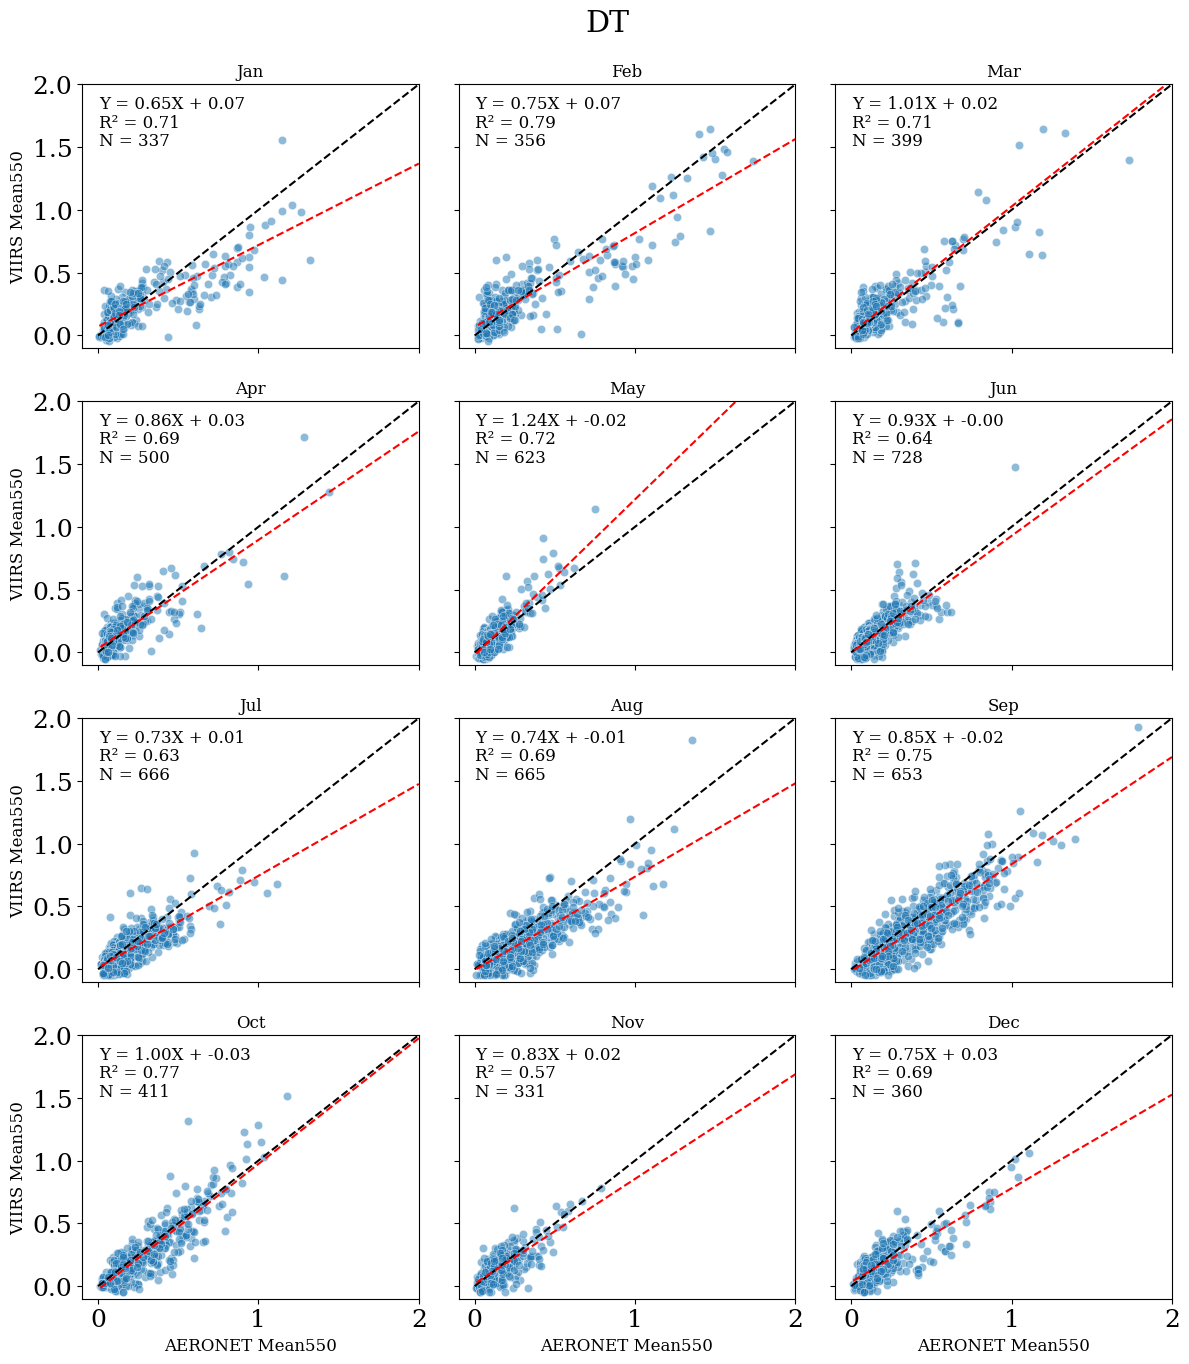

/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/plots/DT_aeronet_vs_viirs_seperate_monthsmatched_DT_1hours_TW.png


In [105]:


# Ensure the 'month' column exists in the DataFrame
unique_months = matched_up_df['month'].unique()
unique_months.sort()

# Create subplots for each month
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_months) / 3)), ncols=3, figsize=(12, 3.5 * int(np.ceil(len(unique_months) / 3))), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each month and plot the data
for i, month in enumerate(unique_months):
    ax = axes[i]
    month_data = matched_up_df[matched_up_df['month'] == month]
    month_name = calendar.month_abbr[int(month)]  # Convert month number to name
    
    # Call the plot_relationship function for the current month
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='aerMean550',
        y_col='satMean550',
        title=f'{month_name}',
        xlabel='AERONET Mean550',
        ylabel='VIIRS Mean550',
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2),
        ylim=(-0.1, 2),
        alpha=0.5,
        figsize=(3, 3),
        fontsize=12,
        palette=None
    )

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle(stat_ret)
plt.tight_layout()
plt.show()

save_path=os.path.join(plots_dir, '{}_aeronet_vs_viirs_seperate_months{}.png'.format(stat_ret,name_tag))
print(save_path)
fig.savefig(save_path, dpi=300)


regression
plot_error_bar
Percentage of Points Within Bounds: 73.59%
regression
plot_error_bar
Percentage of Points Within Bounds: 80.62%
regression
plot_error_bar
Percentage of Points Within Bounds: 79.20%
regression
plot_error_bar
Percentage of Points Within Bounds: 79.80%
regression
plot_error_bar
Percentage of Points Within Bounds: 67.42%
regression
plot_error_bar
Percentage of Points Within Bounds: 74.04%
regression
plot_error_bar
Percentage of Points Within Bounds: 62.31%
regression
plot_error_bar
Percentage of Points Within Bounds: 72.03%
regression
plot_error_bar
Percentage of Points Within Bounds: 65.39%
regression
plot_error_bar
Percentage of Points Within Bounds: 69.59%
regression
plot_error_bar
Percentage of Points Within Bounds: 74.62%
regression
plot_error_bar
Percentage of Points Within Bounds: 71.94%


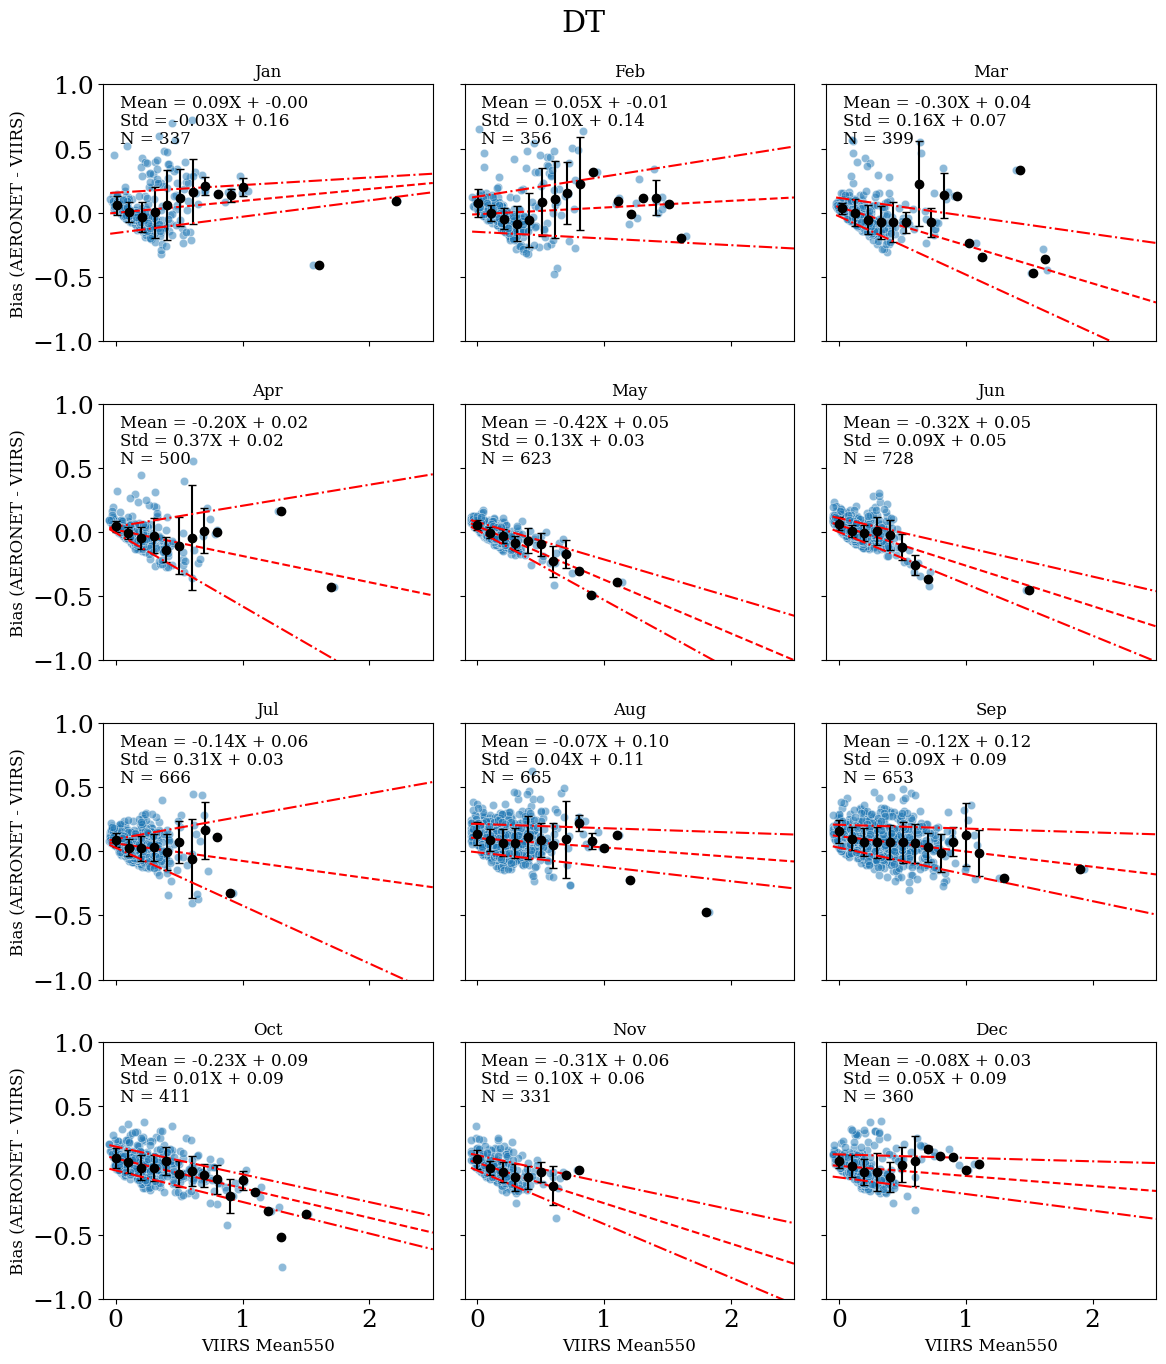

In [106]:
# Ensure the 'month' column exists in the DataFrame
unique_months = matched_up_df['month'].unique()
unique_months.sort()

# Create subplots for each month
fig, axes = plt.subplots(nrows=int(np.ceil(len(unique_months) / 3)), ncols=3, figsize=(12, 3.5 * int(np.ceil(len(unique_months) / 3))), sharex=True, sharey=True)
axes = axes.ravel()

# Loop through each month and plot the bias
for i, month in enumerate(unique_months):
    ax = axes[i]
    month_data = matched_up_df[matched_up_df['month'] == month]
    month_name = calendar.month_abbr[int(month)]  # Convert month number to name
    
    # Call the plot_relationship function for the current month
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='satMean550',
        y_col='bias',
        title=f'{month_name}',
        xlabel='VIIRS Mean550',
        ylabel='Bias (AERONET - VIIRS)',
        one_one_line=False,
        plot_error_bar=True,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-1, 1),
        alpha=0.5,
        figsize=(6, 6),
        fontsize=12,
        palette=None
    )

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)
plt.suptitle(stat_ret)
plt.tight_layout()
plt.show()

save_path=os.path.join(plots_dir, '{}_error_aeronet_vs_viirs_seperate_months{}.png'.format(stat_ret,name_tag))
fig.savefig(save_path, dpi=300)



# Angstrom Exponent Analysis

ASI_Malindi 19.760479041916167 57.48502994011976
Ilorin 27.77777777777778 43.75
SEGC_Lope_Gabon 5.882352941176471 92.15686274509804
AAU_ET 12.0 61.333333333333336
UEM_Maputo 6.60377358490566 85.84905660377359
Mongu_Inn 0.390625 98.4375
Maun_Tower 0.33783783783783783 97.63513513513513
Koforidua_ANUC 38.70967741935484 32.25806451612903
Namibe 16.666666666666668 75.0
Pretoria_CSIR-EC 0.0 99.57627118644068
Skukuza 1.3011152416356877 94.9814126394052
CATUC_Bamenda 16.831683168316832 73.26732673267327
HESS 2.111324376199616 93.47408829174664
Windpoort 2.218430034129693 94.88054607508532
Lubango 3.5714285714285716 93.57142857142857
Cairo_EMA_2 19.791666666666668 71.875
Metsi 0.7067137809187279 97.17314487632508
Misamfu 0.3215434083601286 98.07073954983923
Durban_UKZN 0.0 94.38202247191012
Upington 5.072463768115942 81.8840579710145
Sakeji_School 0.0 99.68553459119497
Niassa 2.3255813953488373 84.88372093023256
Zinder_Airport 57.142857142857146 21.428571428571427
Banizoumbou 20.0 0.0
ICIPE-Mbi

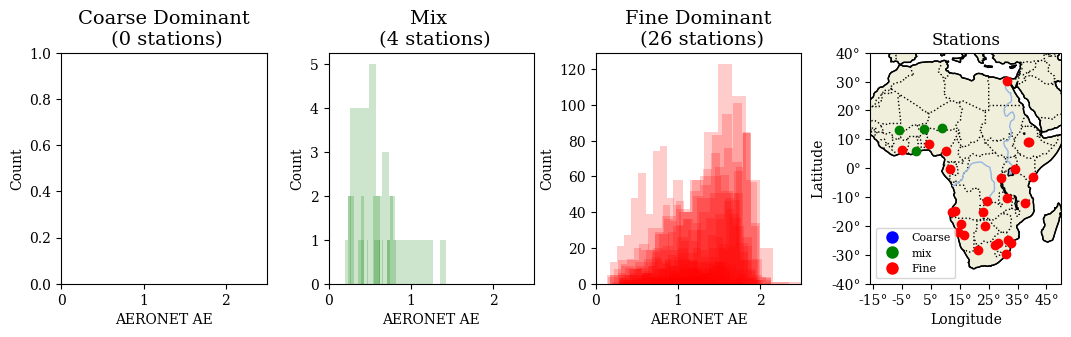

<Figure size 640x480 with 0 Axes>

In [107]:


stations = matched_up_df['staName'].unique()
colors = {'coarse': 'blue', 'fine': 'red', 'mix': 'green'}
alpha = 0.2
plt.rcParams.update({'font.family': [ 'serif'], 'font.size': 10})
# Prepare lists for map
station_lats, station_lons, station_cats, station_labels = [], [], [], []

# Prepare data for each category
hist_data = {'coarse': [], 'fine': [], 'mix': []}
labels = {'coarse': [], 'fine': [], 'mix': []}

for sta in stations:
    sta_df = matched_up_df[matched_up_df['staName'] == sta]
    ae = sta_df['mean_aeronet_ae'].dropna()
    if len(ae) == 0:
        continue
    n_total = len(ae)
    n_coarse = np.sum(ae < 0.5)
    n_fine = np.sum(ae > 0.7)
    n_inter = np.sum((ae >= 0.5) & (ae <= 0.7))
    pct_coarse = 100 * n_coarse / n_total
    pct_fine = 100 * n_fine / n_total
    pct_inter = 100 * n_inter / n_total

    # Assign to dominant category
    if pct_coarse >= 60:
        cat = 'coarse'
    elif pct_fine > pct_coarse and pct_fine > pct_inter:
        cat = 'fine'
    else:
        cat = 'mix'
    hist_data[cat].append(ae)
    labels[cat].append(sta)
    # For map
    station_lats.append(sta_df['staLat'].iloc[0])
    station_lons.append(sta_df['staLon'].iloc[0])
    station_cats.append(cat)
    station_labels.append(sta)
    print(sta,pct_coarse, pct_fine)

# Plot histograms
fig, axes = plt.subplots(1, 4, figsize=(13, 3), gridspec_kw={'width_ratios': [1, 1,1, 1]})

for idx, cat in enumerate(['coarse', 'mix','fine']):
    for ae, sta in zip(hist_data[cat], labels[cat]):
        axes[idx].hist(ae, bins=15, color=colors[cat], alpha=alpha, label=sta)
    #THE NUMBER OF STATIONS IN THE TITLE of each subplot
    n_stations = len(hist_data[cat])
    if cat!='mix':
       
        axes[idx].set_title(f"{cat.capitalize()} Dominant"+'\n'+f" ({n_stations} stations)", fontsize=14)
    else:
        axes[idx].set_title(f"{cat.capitalize()} "+'\n'+f" ({n_stations} stations)", fontsize=14)
    axes[idx].set_xlabel('AERONET AE')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xlim(0, 2.5)
    
    # axes[idx].legend(fontsize=8, loc='upper right')
   

# Map subplot
# Remove the last axes (axes[3]) before adding Cartopy axes
fig.delaxes(axes[3])
ax_map = plt.subplot(1, 4, 4, projection=ccrs.PlateCarree())
ax_map.set_extent([min(station_lons)-10, max(station_lons)+10, min(station_lats)-5, max(station_lats)+5])
ax_map.add_feature(cfeature.BORDERS, linestyle=':')
ax_map.add_feature(cfeature.COASTLINE)
ax_map.add_feature(cfeature.LAND, edgecolor='black')
ax_map.add_feature(cfeature.LAKES, edgecolor='black')
ax_map.add_feature(cfeature.RIVERS)
for lon, lat, cat, label in zip(station_lons, station_lats, station_cats, station_labels):
    ax_map.plot(lon, lat, marker='o', color=colors[cat], markersize=6, transform=ccrs.PlateCarree())
    # ax_map.text(lon, lat, label, fontsize=9, ha='left', va='bottom', transform=ccrs.PlateCarree())
# Custom legend for map
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Coarse', markerfacecolor=colors['coarse'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='mix', markerfacecolor=colors['mix'], markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Fine', markerfacecolor=colors['fine'], markersize=10)]
ax_map.legend(handles=legend_elements, loc='lower left', fontsize=8)
ax_map.set_title('Stations')
# Set longitude and latitude ticks and labels
lon_ticks = np.arange(int(min(station_lons)-10), int(max(station_lons)+11), 10)
# lat_ticks = np.arange(int(min(station_lats)-4), int(max(station_lats)+5), 10)
lat_ticks = np.arange(-40,41, 10)
ax_map.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
ax_map.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
ax_map.set_xticklabels([f"{lon}°" for lon in lon_ticks])
ax_map.set_yticklabels([f"{lat}°" for lat in lat_ticks])
ax_map.set_xlabel('Longitude')
ax_map.set_ylabel('Latitude')

plt.subplots_adjust(wspace=0.3)

# plt.tight_layout()
plt.show()
save_path_coarse = os.path.join(plots_dir, f"{stat_ret}_hist_aeronet_ae_bySTATION_{name_tag}.png")
plt.savefig(save_path_coarse, dpi=300)
plt.show()

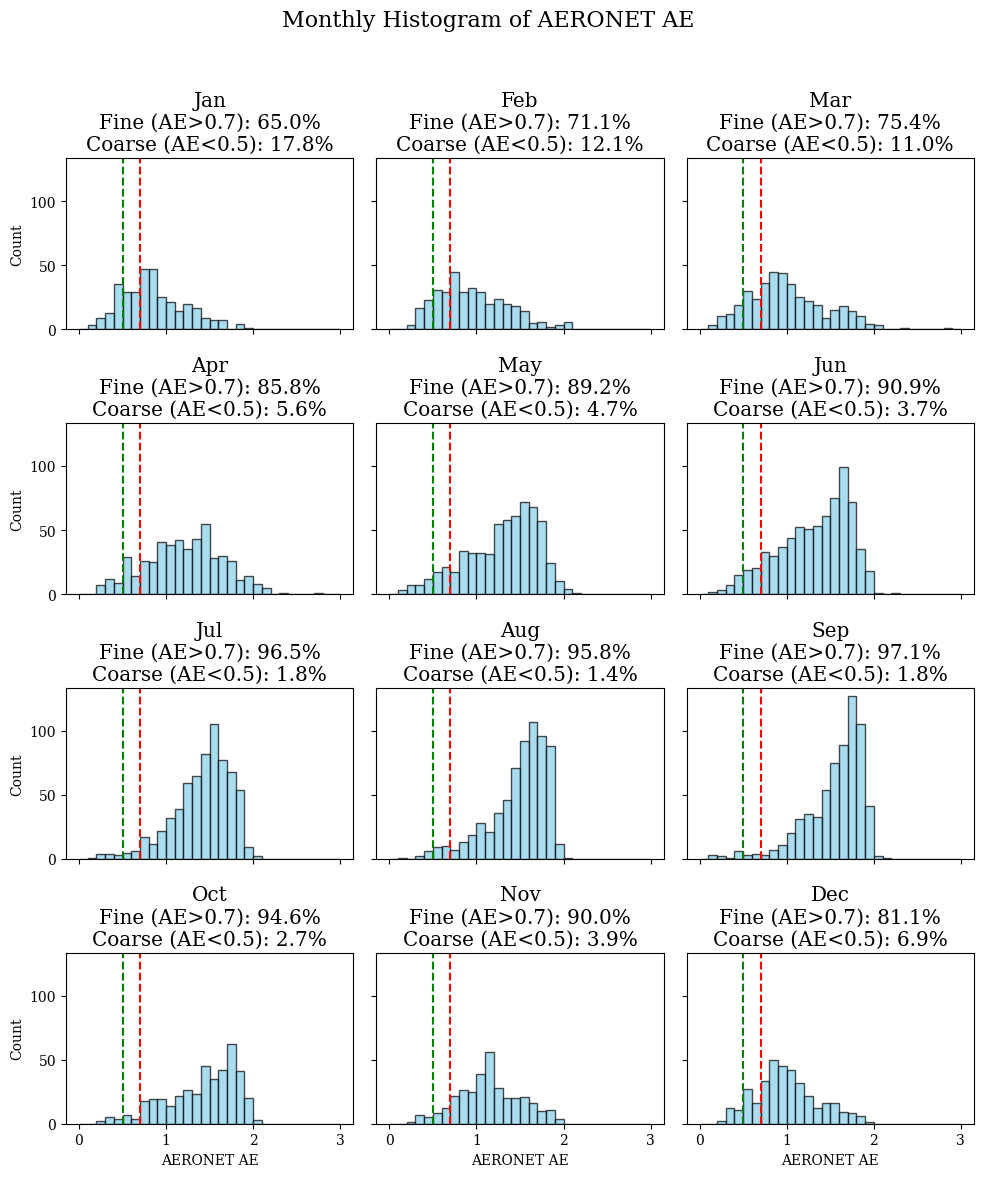

In [108]:


# Ensure 'month' column exists and is string
matched_up_df['month'] = pd.to_datetime(matched_up_df['date']).dt.strftime('%m')
unique_months = [f"{i:02d}" for i in range(1, 13)]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 12), sharex=True, sharey=True)
axes = axes.ravel()
plt.rcParams.update({'font.size': 12})
for idx, month in enumerate(unique_months):
    # Calculate percentages
    month_data = matched_up_df[matched_up_df['month'] == month]
    ae = month_data['mean_aeronet_ae'].dropna()
    n_total = len(ae)
    n_fine = np.sum(ae > 0.7)
    n_coarse = np.sum(ae < 0.5)
    pct_fine = 100 * n_fine / n_total if n_total > 0 else 0
    pct_coarse = 100 * n_coarse / n_total if n_total > 0 else 0
    
    ax = axes[idx]
   
    # Histogram
    ax.hist(ae, bins=np.linspace(0, 3, 31), color='skyblue', edgecolor='k', alpha=0.7)
    ax.set_title(f"{calendar.month_abbr[int(month)]}"+'\n'+ # Annotate
        f"Fine (AE>0.7): {pct_fine:.1f}%"+'\n'
        f"Coarse (AE<0.5): {pct_coarse:.1f}%")
    if idx % 3 == 0:
        ax.set_ylabel('Count')
    if idx >= len(unique_months) - 3:
        ax.set_xlabel('AERONET AE')
   
    
    
   
    # add vertical line at 0.7 and 0.5
    ax.axvline(x=0.7, color='red', linestyle='--', label='AE=0.7')
    ax.axvline(x=0.5, color='green', linestyle='--', label='AE=0.5')

# Hide unused axes
for j in range(len(unique_months), len(axes)):
    axes[j].set_visible(False)
    

plt.suptitle("Monthly Histogram of AERONET AE ", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
save_path_coarse = os.path.join(plots_dir, f"{stat_ret}_hist_aeronet_ae_bymonth_{name_tag}.png")
fig.savefig(save_path_coarse, dpi=300)
plt.show()

In [109]:
#AE less than 0.5 (i.e., sea salt and dust dominated) and  greater than 0.7 (i.e., fine mode pollution and smoke).
#slipt my data based on threshold mean_aeronet_ae less than 0.5 and greater than 0.7 and plot  ylabel='Bias (AERONET - VIIRS)'
matched_up_df['mean_aeronet_ae'] = matched_up_df['mean_aeronet_ae'].astype(float)
matched_up_df['mean_aeronet_ae'] = matched_up_df['mean_aeronet_ae'].replace(-999.0, np.nan)

# Filter the data based on the ae threshold
ae_coarsethreshold = 0.5
ae_finethreshold = 0.7
matched_up_df['ae_coarse'] = matched_up_df['mean_aeronet_ae'] <= ae_coarsethreshold
coarse_df = matched_up_df[matched_up_df['ae_coarse']]

matched_up_df['ae_fine'] = matched_up_df['mean_aeronet_ae'] >= ae_finethreshold
fine_df = matched_up_df[matched_up_df['ae_fine']]

/tmp/ipykernel_68416/1472781640.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fine_df['month'] = pd.to_datetime(fine_df['date']).dt.strftime('%m')
/tmp/ipykernel_68416/1472781640.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coarse_df['month'] = pd.to_datetime(coarse_df['date']).dt.strftime('%m')


regression
Iteration 1: 89.50% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 89.72% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 89.04% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 86.01% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 82.73% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 80.36% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 81.03% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 82.10% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 88.17% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 87.15% of points within bounds.
Optimization converged after 1 iterations.
regression

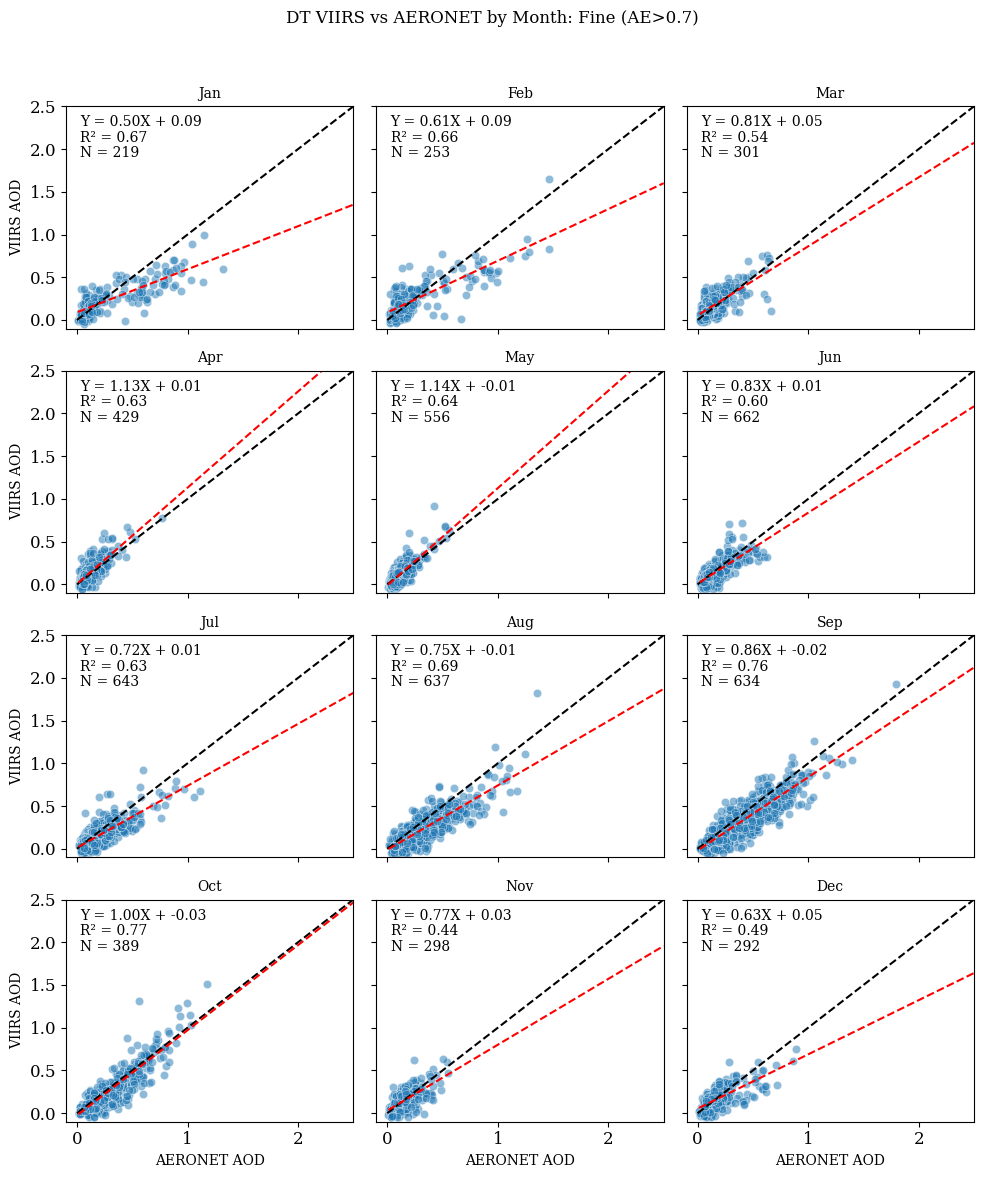

regression
Iteration 1: 91.67% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 93.02% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 65.91% of points within bounds.
Iteration 2: 70.45% of points within bounds.
Optimization converged after 2 iterations.
regression
Iteration 1: 92.86% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 100.00% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 100.00% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 100.00% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 77.78% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 75.00% of points within bounds.
Optimization converged after 1 iterations.
regression
Iteration 1: 100.00% of points within bounds.
Opti

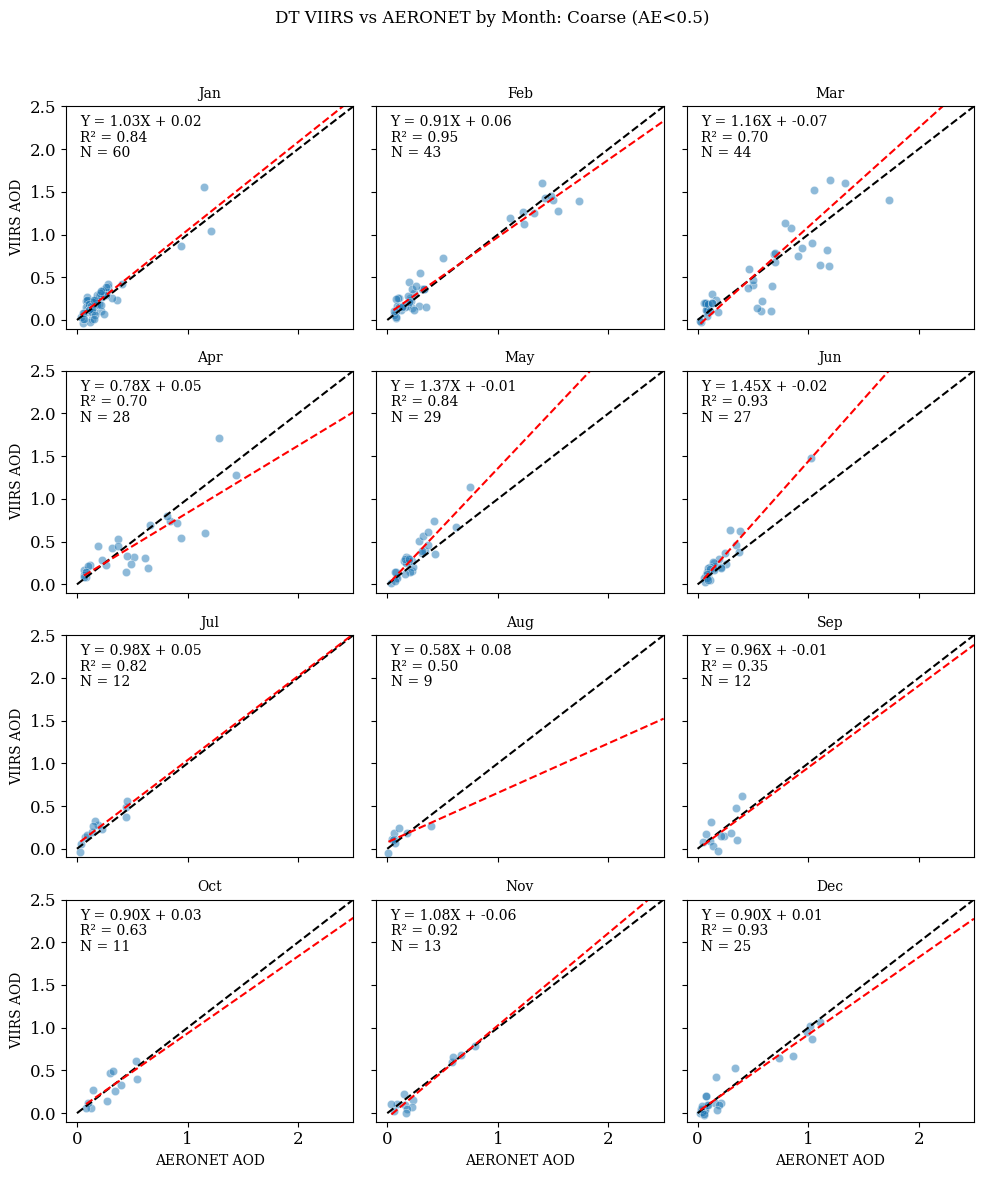

In [110]:
#plotting viirs vs aeronet by month for the coarse and fine mode


# Ensure 'month' column exists
fine_df['month'] = pd.to_datetime(fine_df['date']).dt.strftime('%m')
coarse_df['month'] = pd.to_datetime(coarse_df['date']).dt.strftime('%m')
unique_months = [f"{i:02d}" for i in range(1, 13)]

# all font size set to 14
plt.rcParams.update({'font.size': 12})

# --- Fine mode VIIRS vs AERONET by month ---
fig_fine, axes_fine = plt.subplots(nrows=4, ncols=3, figsize=(10, 12), sharex=True, sharey=True)
axes_fine = axes_fine.ravel()
for idx, month in enumerate(unique_months):
    ax = axes_fine[idx]
    month_data = fine_df[fine_df['month'] == month]
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='aerMean550',
        y_col='satMean550',
        title=f"{calendar.month_abbr[int(month)]}",
        xlabel='AERONET AOD' if idx >= 9 else '',
        ylabel='VIIRS AOD' if idx % 3 == 0 else '',
        one_one_line=True,
        plot_error_bar=False,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-0.1, 2.5),
        alpha=0.5,
        figsize=(6, 4),
        fontsize=10,
        palette=None
    )
for j in range(len(unique_months), len(axes_fine)):
    axes_fine[j].set_visible(False)
fig_fine.suptitle(f"{stat_ret} VIIRS vs AERONET by Month: Fine (AE>0.7)", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_path_fine = os.path.join(plots_dir, f"{stat_ret}_viirs_vs_aeronet_fine_bymonth_{name_tag}.png")
plt.savefig(save_path_fine, dpi=300)
plt.show()

# --- Coarse mode VIIRS vs AERONET by month ---
fig_coarse, axes_coarse = plt.subplots(nrows=4, ncols=3, figsize=(10, 12), sharex=True, sharey=True)
axes_coarse = axes_coarse.ravel()
for idx, month in enumerate(unique_months):
    ax = axes_coarse[idx]
    month_data = coarse_df[coarse_df['month'] == month]
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='aerMean550',
        y_col='satMean550',
        title=f"{calendar.month_abbr[int(month)]}",
        xlabel='AERONET AOD' if idx >= 9 else '',
        ylabel='VIIRS AOD' if idx % 3 == 0 else '',
        one_one_line=True,
        plot_error_bar=False,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-0.1, 2.5),
        alpha=0.5,
        figsize=(4, 4),
        fontsize=10,
        palette=None
    )
for j in range(len(unique_months), len(axes_coarse)):
    axes_coarse[j].set_visible(False)
fig_coarse.suptitle(f"{stat_ret} VIIRS vs AERONET by Month: Coarse (AE<0.5)", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_path_coarse = os.path.join(plots_dir, f"{stat_ret}_viirs_vs_aeronet_coarse_bymonth_{name_tag}.png")
fig.savefig(save_path_coarse, dpi=300)
plt.show()

regression
plot_error_bar
Percentage of Points Within Bounds: 75.40%
regression
plot_error_bar
Percentage of Points Within Bounds: 78.22%


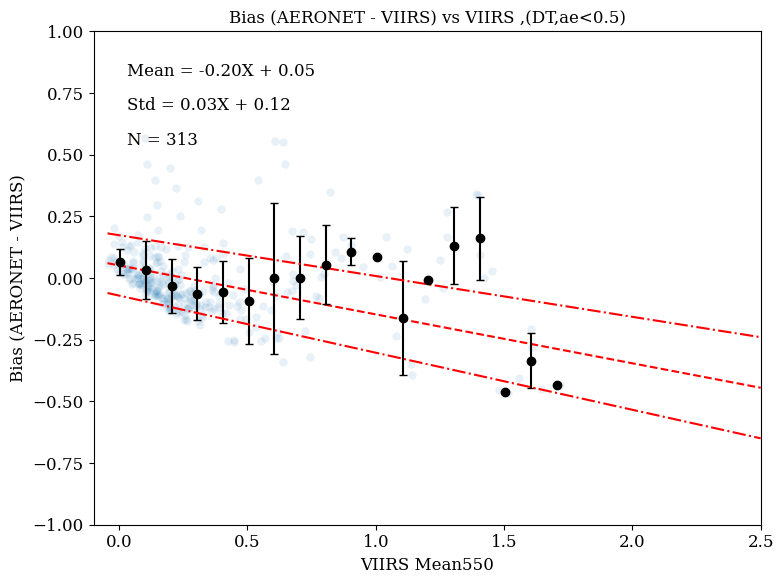

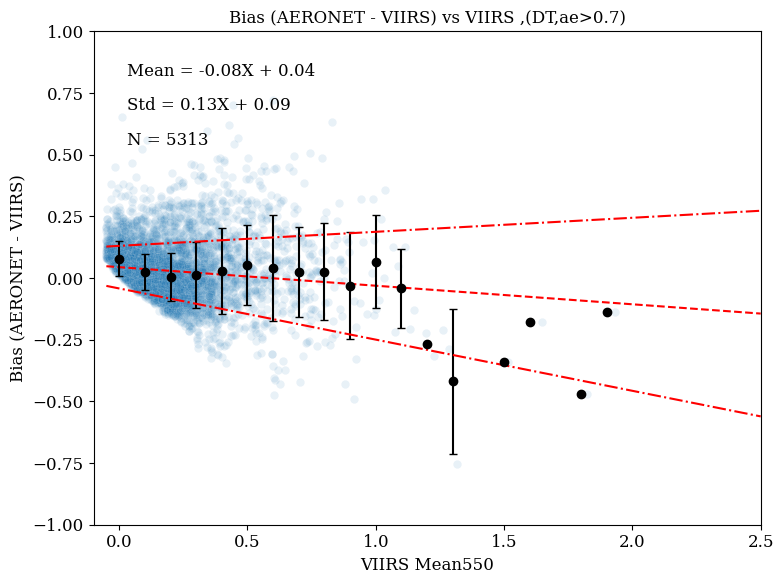

In [111]:
\


#plot  ylabel='Bias (AERONET - VIIRS)'
slope, intercept, slope_std, intercept_std=plot_relationship(
    df=coarse_df,
    x_col='satMean550',
    y_col='bias',
    # hue_col='ae_coarse',
    title='Bias (AERONET - VIIRS) vs VIIRS ,({},{})'.format(stat_ret,'ae<0.5'),
    xlabel='VIIRS Mean550',
    ylabel='Bias (AERONET - VIIRS)',
    plot_error_bar=True,
    one_one_line=False,
    # legend_title='AE < 0.5',
    # legend_loc='upper right',
    save_path=os.path.join(plots_dir, '{}_error_aeronet_vs_viirs_coarse{}.png'.format(stat_ret,name_tag)),
    regression=True,
    xlim=(-0.1, 2.5),
    ylim=(-1, 1),
    alpha=0.1,
    figsize=(8, 6),
    fontsize=12,
    palette=None
)

# plot fine ae
slope, intercept, slope_std, intercept_std=plot_relationship(
    df=fine_df,
    x_col='satMean550',
    y_col='bias',
    # hue_col='ae_fine',
    title='Bias (AERONET - VIIRS) vs VIIRS ,({},{})'.format(stat_ret,'ae>0.7'),
    xlabel='VIIRS Mean550',
    ylabel='Bias (AERONET - VIIRS)',
    plot_error_bar=True,
    one_one_line=False,
    # legend_title='AE > 0.7',
    # legend_loc='upper right',
    save_path=os.path.join(plots_dir, '{}_error_aeronet_vs_viirs_fine{}.png'.format(stat_ret,name_tag)),
    regression=True,
    xlim=(-0.1, 2.5),
    ylim=(-1, 1),
    alpha=0.1,
    figsize=(8, 6),
    fontsize=12,
    palette=None
)




/tmp/ipykernel_68416/1423677266.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fine_df['month'] = pd.to_datetime(fine_df['date']).dt.strftime('%m')
/tmp/ipykernel_68416/1423677266.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coarse_df['month'] = pd.to_datetime(coarse_df['date']).dt.strftime('%m')


regression
plot_error_bar
Percentage of Points Within Bounds: 72.60%
regression
plot_error_bar
Percentage of Points Within Bounds: 68.77%
regression
plot_error_bar
Percentage of Points Within Bounds: 77.74%
regression
plot_error_bar
Percentage of Points Within Bounds: 77.39%
regression
plot_error_bar
Percentage of Points Within Bounds: 69.78%
regression
plot_error_bar
Percentage of Points Within Bounds: 72.36%
regression
plot_error_bar
Percentage of Points Within Bounds: 61.74%
regression
plot_error_bar
Percentage of Points Within Bounds: 72.21%
regression
plot_error_bar
Percentage of Points Within Bounds: 65.46%
regression
plot_error_bar
Percentage of Points Within Bounds: 69.67%
regression
plot_error_bar
Percentage of Points Within Bounds: 75.84%
regression
plot_error_bar
Percentage of Points Within Bounds: 72.95%


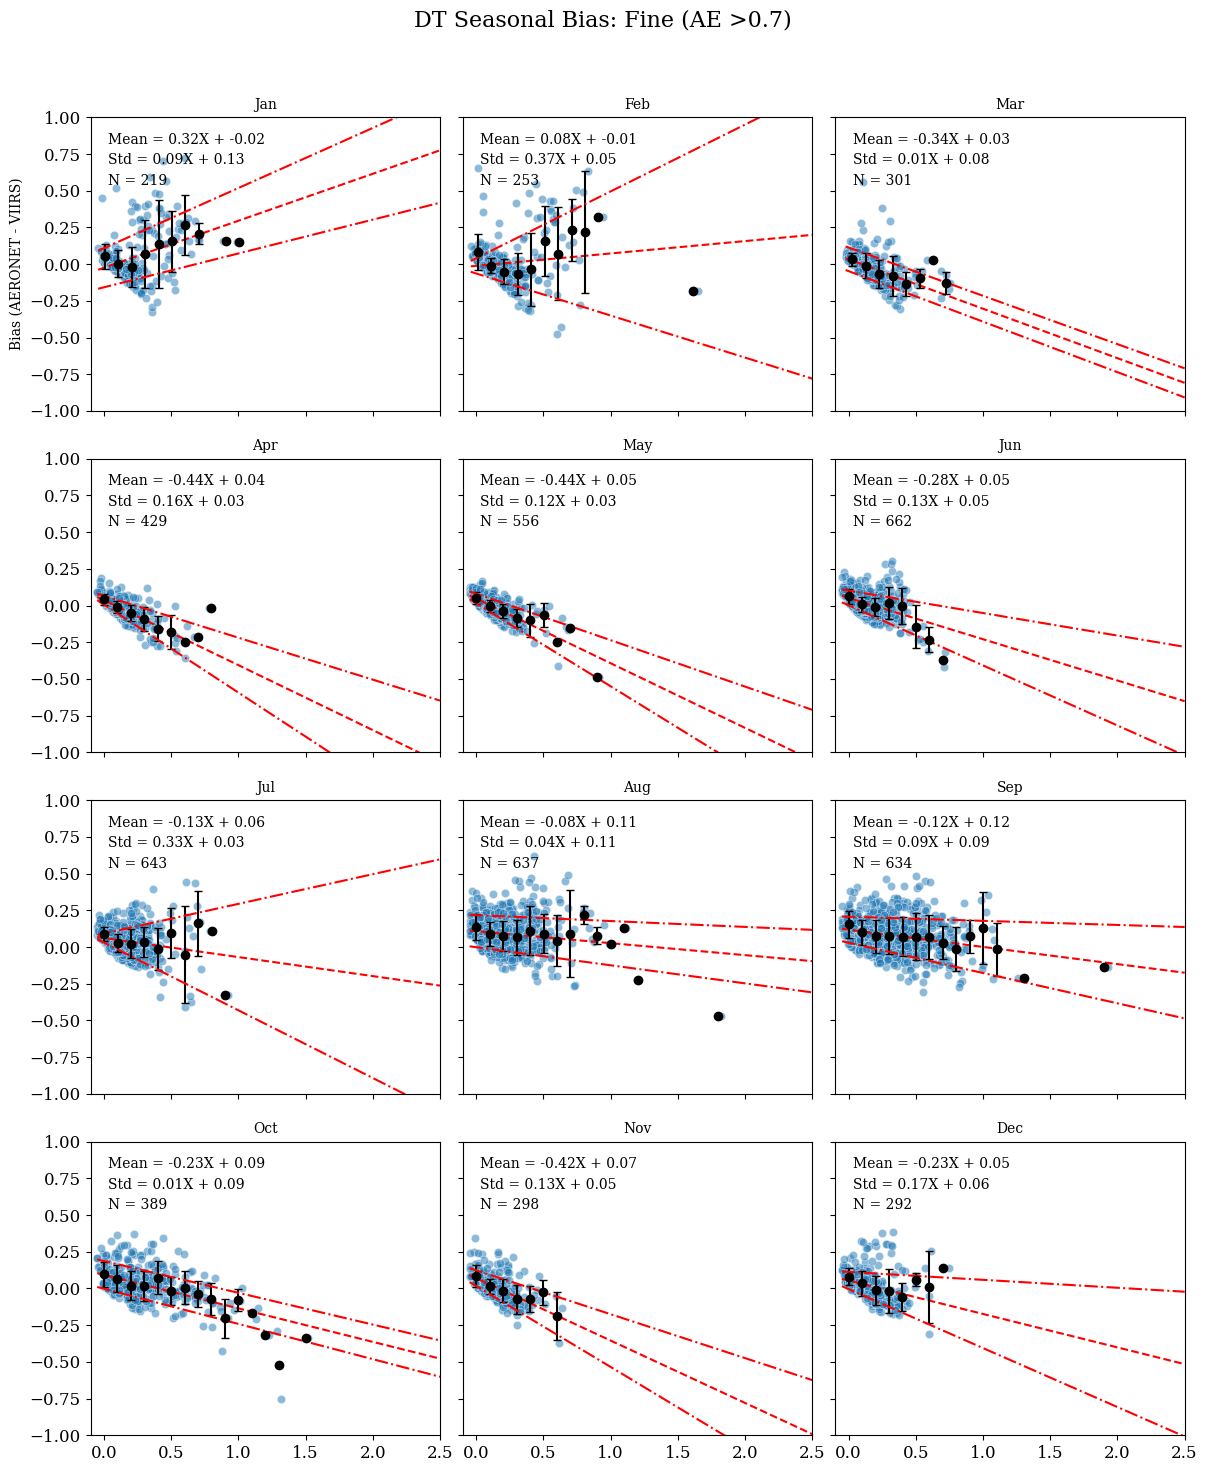

regression
plot_error_bar
Percentage of Points Within Bounds: 51.67%
regression
plot_error_bar
Percentage of Points Within Bounds: 58.14%
regression
plot_error_bar
Percentage of Points Within Bounds: 34.09%
regression
plot_error_bar
Percentage of Points Within Bounds: 46.43%
regression
plot_error_bar
Percentage of Points Within Bounds: 58.62%
regression
plot_error_bar
Percentage of Points Within Bounds: 70.37%
regression
plot_error_bar
Percentage of Points Within Bounds: 33.33%
regression
plot_error_bar
Percentage of Points Within Bounds: 33.33%
regression
plot_error_bar
Percentage of Points Within Bounds: 91.67%
regression
plot_error_bar
Percentage of Points Within Bounds: 72.73%
regression
plot_error_bar
Percentage of Points Within Bounds: 46.15%
regression
plot_error_bar
Percentage of Points Within Bounds: 56.00%


/tmp/ipykernel_68416/2146484579.py:116: RankWarning: Polyfit may be poorly conditioned
  slope_std, intercept_std = np.polyfit(bin_centers, stds, 1)


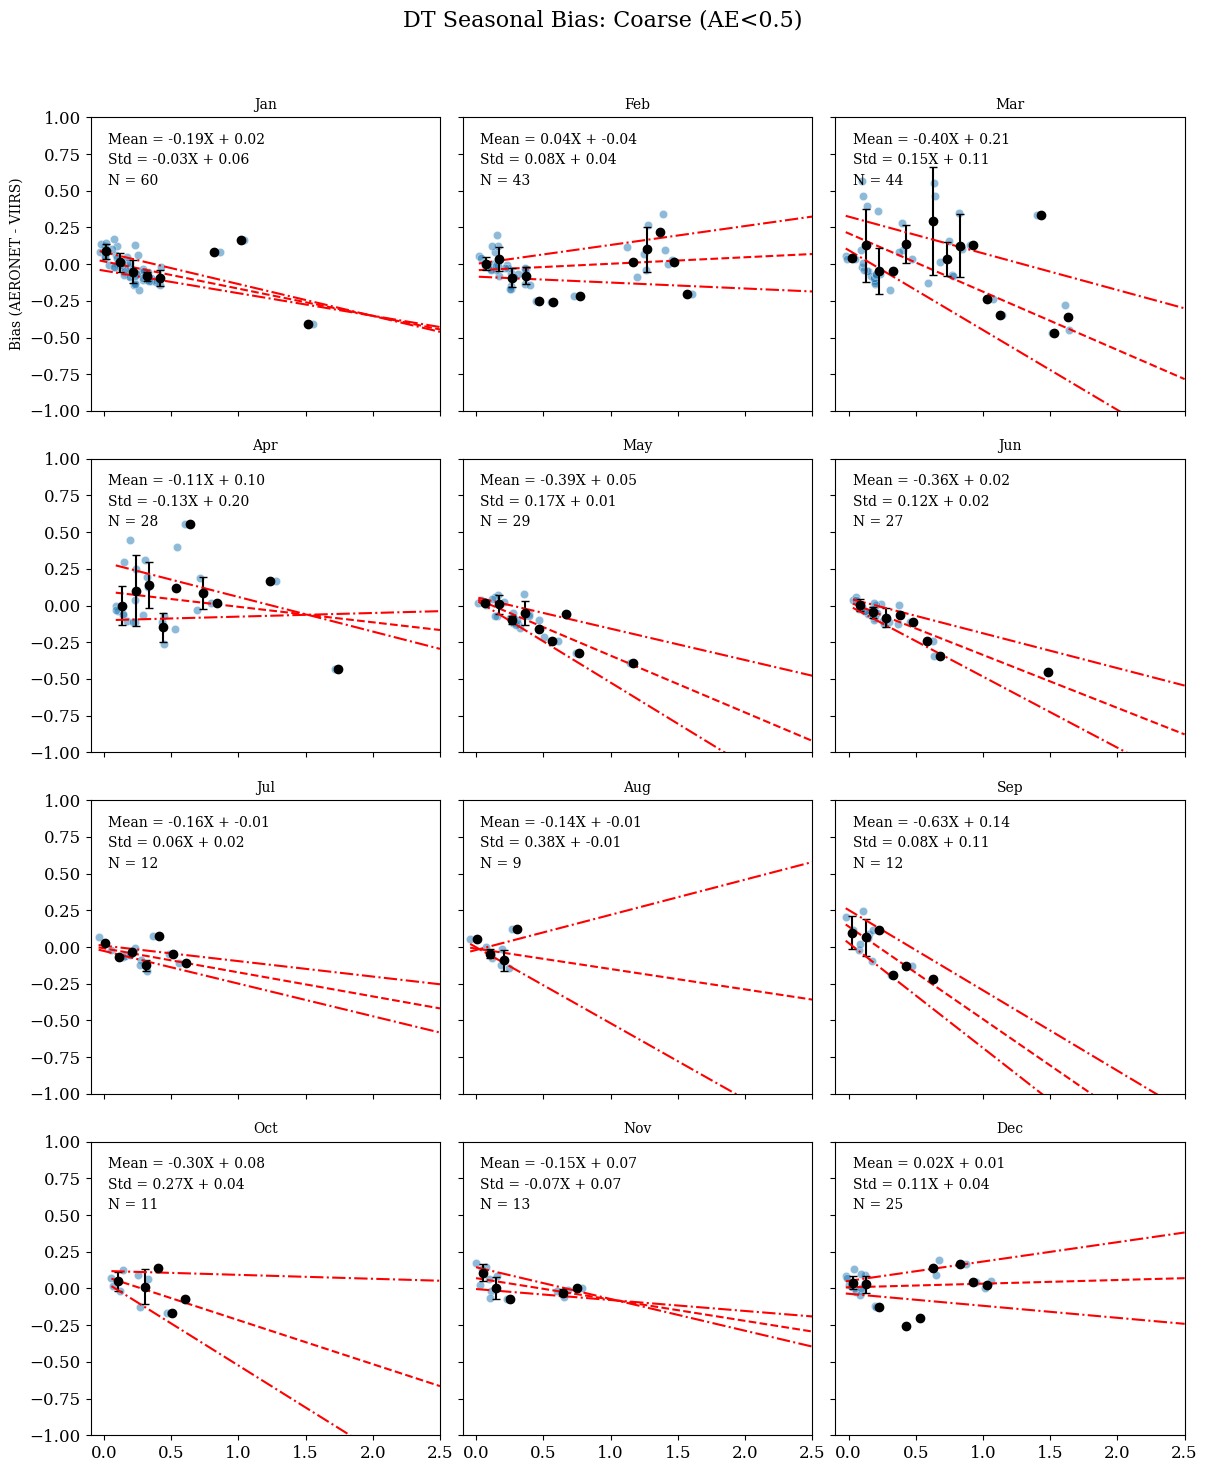

In [112]:
#plotting seasonal plots for fine and then coarse in two subplots



# Ensure 'month' column exists
fine_df['month'] = pd.to_datetime(fine_df['date']).dt.strftime('%m')
coarse_df['month'] = pd.to_datetime(coarse_df['date']).dt.strftime('%m')
unique_months = [f"{i:02d}" for i in range(1, 13)]

# --- Fine mode plot ---
fig_fine, axes_fine = plt.subplots(nrows=4, ncols=3, figsize=(12,15), sharex=True, sharey=True)
axes_fine = axes_fine.ravel()
for idx, month in enumerate(unique_months):
    ax = axes_fine[idx]
    month_data = fine_df[fine_df['month'] == month]
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='satMean550',
        y_col='bias',
        title=f"{calendar.month_abbr[int(month)]}",
        xlabel='VIIRS Mean550' if idx == 0 else '',
        ylabel='Bias (AERONET - VIIRS)' if idx == 0 else '',
        one_one_line=False,
        plot_error_bar=True,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-1, 1),
        alpha=0.5,
        figsize=(6, 4),
        fontsize=10,
        palette=None
    )
fig_fine.suptitle(f"{stat_ret} Seasonal Bias: Fine (AE >0.7)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_path_fine = os.path.join(plots_dir, f"{stat_ret}_seasonal_bias_fine_{name_tag}.png")
fig.savefig(save_path_fine, dpi=300)
plt.show()

# --- Coarse mode plot ---
fig_coarse, axes_coarse = plt.subplots(nrows=4, ncols=3, figsize=(12,15), sharex=True, sharey=True)
axes_coarse = axes_coarse.ravel()
for idx, month in enumerate(unique_months):
    ax = axes_coarse[idx]
    month_data = coarse_df[coarse_df['month'] == month]
    plot_relationship(
        ax=ax,
        df=month_data,
        x_col='satMean550',
        y_col='bias',
        title=f"{calendar.month_abbr[int(month)]}",
        xlabel='VIIRS Mean550' if idx == 0 else '',
        ylabel='Bias (AERONET - VIIRS)' if idx == 0 else '',
        one_one_line=False,
        plot_error_bar=True,
        legend_title=None,
        legend_loc='upper right',
        regression=True,
        xlim=(-0.1, 2.5),
        ylim=(-1, 1),
        alpha=0.5,
        figsize=(6, 4),
        fontsize=10,
        palette=None
    )
fig_coarse.suptitle(f"{stat_ret} Seasonal Bias: Coarse (AE<0.5)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_path_coarse = os.path.join(plots_dir, f"{stat_ret}_seasonal_bias_coarse_{name_tag}.png")
fig.savefig(save_path_coarse, dpi=300)
plt.show()


# the rest are test on code accuracy

In [ ]:
#this is to just check the laast site that is created through "create_aeronet_site.py"
from glob import glob
station_file_dir='/glade/campaign/acom/acom-da/SERVIR/ind-obs/aeronet/AOD_Level15_All_Points_V3/AOD/AOD15/ALL_POINTS/'
#get all the files in the directory and sort them and file the selected stations in a list
station_files=glob(station_file_dir+'*.lev15')
station_files.sort()

station_sel='Zvenigorod'
station_files_sel=[file for file in station_files if station_sel in file]
#print the index of the selected station
station_files_sel_index=[i for i, file in enumerate(station_files) if station_sel in file]
print(station_files_sel_index, station_files_sel)
#read the files in pandas and concatenate them


[1564] ['/glade/campaign/acom/acom-da/SERVIR/ind-obs/aeronet/AOD_Level15_All_Points_V3/AOD/AOD15/ALL_POINTS/19930101_20250329_Zvenigorod.lev15']


In [97]:
test_final_out='/glade/campaign/acom/acom-da/SERVIR/match_aeronet_viirs/matched_DB_1hours_TW/Match_DB_2022121.csv'
#read the file in pandas
test_final_out_df=pd.read_csv(test_final_out)
display(test_final_out_df)

#test input reformatted
formatted_input_dir='/glade/campaign/acom/acom-da/SERVIR/ind-obs/aeronet/AOD_Level15_All_Points_V3/for/2022/121/ASI_Malindi.dat'
#read the file in pandas
formatted_input_df=pd.read_csv(formatted_input_dir, sep=',', header=None)

AERONET_WAVELENGTHS = [1.640, 1.020, 0.870, 0.865, 0.779, 0.675, 0.667, 0.620,
                       0.560, 0.555, 0.551, 0.532, 0.531, 0.510, 0.500, 0.490,
                       0.443, 0.440, 0.412, 0.400, 0.380, 0.340]
#recereate column names
reformated_columns = ["Date(dd:mm:yyyy)", "Time(hh:mm:ss)","Day_of_Year(Fraction)"] + [f"AOD_{int(w*1000)}nm" for w in AERONET_WAVELENGTHS]+["440-870_Angstrom_Exponent"]
#add the columns to the dataframe
formatted_input_df.columns = reformated_columns
# find formatted_input_df['Time(hh:mm:ss)'] in +,-30 min of test_final_out_df['time']
# convert the time columns to datetime
# from the formatted_input_df we see that we need to average 7 elements around 10.9 which looking at formatted_input_df are row 9 to 15
mean_row = formatted_input_df.iloc[9:16].mean(numeric_only=True)
print(mean_row["440-870_Angstrom_Exponent"],test_final_out_df['mean_aeronet_ae'][0])


# lev15 data
dir_lev15='/glade/campaign/acom/acom-da/SERVIR/ind-obs/aeronet/AOD_Level15_All_Points_V3/AOD/AOD15/ALL_POINTS/19930101_20250329_ASI_Malindi.lev15'
#read the file in pandas
# Find the header row number (for example, 5 means skip first 5 lines)
with open(dir_lev15) as f:
    for i, line in enumerate(f):
        if line.startswith('Date(dd:mm:yyyy)'):
            header_row = i
            break

# Now read the file, skipping metadata
lev15_df = pd.read_csv(dir_lev15, skiprows=header_row, header=0)
# find 20220501	ind date
lev15_df['Date(dd:mm:yyyy)'] = pd.to_datetime(lev15_df['Date(dd:mm:yyyy)'], format='%d:%m:%Y')
lev15_df
lev15mask = lev15_df['Date(dd:mm:yyyy)'] == pd.Timestamp('2022-05-01')
lev15_20220501 = lev15_df[lev15mask]
pd.set_option('display.max_columns', None)

# looking at the data we see that we need to average 7 elements around 10.9 which looking at lev15_20220501 are row 43786 to 43792
#lets make sure column values are converted to float from string
# lev15_20220501 = lev15_20220501.apply(pd.to_numeric, errors='coerce')
display(lev15_20220501)
mean_row = lev15_df.iloc[43786:43793]
mean_row=mean_row.mean(numeric_only=True)
mean_row["440-870_Angstrom_Exponent"]
# mean_row

date  nMeas  nPixs  satTime      staName    staLon   staLat  \
0  20220501      7     10     10.9  ASI_Malindi  40.19450  -2.9960   
1  20220501      4     27     12.7  Banizoumbou   2.66475  13.5412   

   aerMean550  aerSTD550  mean_aeronet_ae  satMean550  satSTD550  \
0    0.099962   0.006052         0.247529    0.250048   0.044499   
1    0.342257   0.018988         0.224516    0.419577   0.104224   

                                              aod550  \
0  0.235672;0.234979;0.216258;0.199341;0.248299;0...   
1  0.419402;0.351459;0.294275;0.300535;0.251485;0...   

                                                  qf  
0                                0;0;0;0;0;0;0;0;0;0  
1  0;16448;0;16448;0;16448;0;16384;0;16448;0;1644...

0.2475294285714286 0.247529


Date(dd:mm:yyyy) Time(hh:mm:ss)  Day_of_Year  Day_of_Year(Fraction)  \
43777       2022-05-01       06:11:01          121             121.257650   
43778       2022-05-01       06:26:42          121             121.268542   
43779       2022-05-01       07:57:03          121             121.331285   
43780       2022-05-01       08:02:03          121             121.334757   
43781       2022-05-01       08:17:03          121             121.345174   
43782       2022-05-01       09:07:04          121             121.379907   
43783       2022-05-01       10:02:03          121             121.418090   
43784       2022-05-01       10:12:03          121             121.425035   
43785       2022-05-01       10:17:03          121             121.428507   
43786       2022-05-01       10:32:03          121             121.438924   
43787       2022-05-01       10:37:03          121             121.442396   
43788       2022-05-01       10:42:03          121             121.445868   
43789       2022-05-01       10:47:03          121             121.449340   
43790       2022-05-01       10:52:03          121             121.452812   
43791       2022-05-01       11:02:03          121             121.459757   
43792       2022-05-01       11:17:03          121             121.470174   
43793       2022-05-01       11:37:03          121             121.484062   
43794       2022-05-01       11:42:03          121             121.487535   
43795       2022-05-01       11:47:03          121             121.491007   
43796       2022-05-01       11:57:02          121             121.497940   
43797       2022-05-01       12:42:02          121             121.529190   
43798       2022-05-01       13:18:50          121             121.554745   
43799       2022-05-01       13:37:01          121             121.567373   
43800       2022-05-01       13:52:01          121             121.577789   
43801       2022-05-01       13:54:00          121             121.579167   

       AOD_1640nm  AOD_1020nm  AOD_870nm  AOD_865nm  AOD_779nm  AOD_675nm  \
43777    0.159616    0.169970   0.170143     -999.0     -999.0   0.170927   
43778    0.177119    0.184446   0.185315     -999.0     -999.0   0.185106   
43779    0.128404    0.145894   0.150081     -999.0     -999.0   0.150879   
43780    0.106730    0.124911   0.129959     -999.0     -999.0   0.130862   
43781    0.131968    0.150437   0.154860     -999.0     -999.0   0.154675   
43782    0.171355    0.176695   0.183666     -999.0     -999.0   0.180649   
43783    0.141023    0.147926   0.148773     -999.0     -999.0   0.147765   
43784    0.086829    0.098954   0.102903     -999.0     -999.0   0.104095   
43785    0.091447    0.107636   0.109433     -999.0     -999.0   0.109067   
43786    0.074032    0.091093   0.096324     -999.0     -999.0   0.098938   
43787    0.077717    0.094388   0.100011     -999.0     -999.0   0.102983   
43788    0.060187    0.076235   0.081913     -999.0     -999.0   0.085485   
43789    0.069983    0.086100   0.090837     -999.0     -999.0   0.092923   
43790    0.067814    0.083626   0.089721     -999.0     -999.0   0.091779   
43791    0.077188    0.092917   0.097482     -999.0     -999.0   0.099025   
43792    0.062367    0.079222   0.083438     -999.0     -999.0   0.086744   
43793    0.093810    0.106666   0.111975     -999.0     -999.0   0.113877   
43794    0.090926    0.104511   0.107884     -999.0     -999.0   0.109593   
43795    0.108929    0.122873   0.124656     -999.0     -999.0   0.125755   
43796    0.127391    0.135991   0.139079     -999.0     -999.0   0.137795   
43797    0.076214    0.089557   0.093784     -999.0     -999.0   0.096516   
43798    0.100133    0.112059   0.114342     -999.0     -999.0   0.115731   
43799    0.111593    0.122693   0.124018     -999.0     -999.0   0.124981   
43800    0.101737    0.112113   0.114000     -999.0     -999.0   0.115250   
43801    0.094088    0.103976   0.107250     -999.0     -999.0   0.110829   



0.2475294285714286

In [ ]:


# # Example usage
# slope_mean, intercept_mean, slope_std, intercept_std, percentage_within_bounds = optimize_regression_fit_np_error_2aod(
#     df=matched_up_df,
#     x_col='satMean550',
#     y_col='bias'
# )

# print(f"Optimized Slope (Mean): {slope_mean}")
# print(f"Optimized Intercept (Mean): {intercept_mean}")
# print(f"Optimized Slope (Std): {slope_std}")
# print(f"Optimized Intercept (Std): {intercept_std}")
# print(f"Percentage of Points Within Bounds: {percentage_within_bounds:.2%}")
# slope_mean, intercept_mean, slope_std, intercept_std,